# Developing a unified representation of Alzheimer’s subtypes

# Part 2: SuStaIn Clustering

After the data preparation has been completed, the filtered data sets can be used to cluster and assess the subtypes. 

SuStaIn - Subtype and Stage Inference is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. In this study I use the linear z-score model [Young et al. 2018](https://doi.org/10.1038/s41467-018-05892-0), because this portrays a linear progression pattern (evolution) where the biomarkers evolve over time and can be compared. SuStaIn assumes that the biomarkers begin at 0 at stage 0, and change in a positive direction (increase with progression), reaching Z_max at the final stage of progression. The number of stages between stage 0 and Z_max is determined by the biomarkers and z-scores determined in Z_vals, which is a set of z-scores per biomarker.
The MRI volumes should reduce over time while the PET should increase.

I determined the z-scores relevant per biomarker, assessed the means and standard deviation per biomarker and defined the number relevant of subtypes. 

Train set MRI - 

## Import packages 

In [6]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
import sklearn.model_selection
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")


sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

## 1. Reading all relevant data. 

In [7]:
data_mri = pd.read_csv('Train_MRI_Modality_1.csv')
data_mri.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2010-12-21               CN        1.0   91     26.0    0.0      14.0   
1   30  2007-11-13         Dementia        3.0  100     22.0    0.0      19.0   
2   72  2019-10-16               CN        1.0   90     28.0    0.0      16.0   
3   74  2021-01-11               CN        1.0   98     29.0    0.0      20.0   
4   86  2006-05-08               CN        1.0  100      0.0    0.0      18.0   

   PTGENDER  AGE_RETIRE  ...  Frontal_lobe_Asymmetry_MRI_L  \
0       1.0        76.0  ...                        0.0154   
1       2.0        59.0  ...                        0.0133   
2       1.0         0.0  ...                        0.0142   
3       1.0        74.0  ...                        0.0145   
4       2.0        66.0  ...                        0.0074   

   Frontal_lobe_Asymmetry_MRI_R  Occipital_lobe_Asymmetry_MRI_L  \
0                       -0.0154                          0.0207   
1                       -0.0133                          0.0101   
2                       -0.0142                         -0.0142   
3                       -0.0145                         -0.0093   
4                       -0.0074                         -0.0005   

   Occipital_lobe_Asymmetry_MRI_R  Parietal_lobe_Asymmetry_MRI_L  \
0                         -0.0207                        -0.0345   
1                         -0.0101                         0.0046   
2                          0.0142                        -0.0307   
3                          0.0093                        -0.0273   
4                          0.0005                         0.0213   

   Parietal_lobe_Asymmetry_MRI_R  Temporal_lobe_Asymmetry_MRI_L  \
0                         0.0345                        -0.0272   
1                        -0.0046                         0.0664   
2                         0.0307                         0.0257   
3                         0.0273                         0.0171   
4                        -0.0213                         0.0070   

   Temporal_lobe_Asymmetry_MRI_R  MTL_Asymmetry_MRI_L  MTL_Asymmetry_MRI_R  
0                         0.0272              -0.0410               0.0410  
1                        -0.0664               0.0061              -0.0061  
2                        -0.0257              -0.0295               0.0295  
3                        -0.0171               0.0618              -0.0618  
4                        -0.0070               0.0647              -0.0647  

[5 rows x 26 columns]

In [8]:
data_ab = pd.read_csv('Train_AB_Modality_2.csv')
data_ab.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2012-12-27               CN        1.0   91     28.0    0.0      14.0   
1   42  2011-04-13         Dementia        3.0   93     23.0    0.0      18.0   
2   58  2011-04-27               CN        1.0   90     29.0    1.0      16.0   
3   61  2013-02-06              MCI        2.0   97     25.0    0.0      15.0   
4   74  2012-12-11               CN        1.0   98     30.0    0.0      20.0   

   PTGENDER  AGE_RETIRE  ...  Frontal_lobe_Asymmetry_ab_L  \
0       1.0        55.0  ...                      -0.0462   
1       1.0        55.0  ...                      -0.0025   
2       1.0         0.0  ...                       0.0066   
3       2.0        62.0  ...                       0.0339   
4       1.0        74.0  ...                      -0.0013   

   Frontal_lobe_Asymmetry_ab_R  Occipital_lobe_Asymmetry_ab_L  \
0                       0.0462                        -0.0721   
1                       0.0025                         0.0161   
2                      -0.0066                        -0.0134   
3                      -0.0339                         0.0360   
4                       0.0013                        -0.0121   

   Occipital_lobe_Asymmetry_ab_R  Parietal_lobe_Asymmetry_ab_L  \
0                         0.0721                       -0.0685   
1                        -0.0161                        0.0098   
2                         0.0134                       -0.0073   
3                        -0.0360                        0.0174   
4                         0.0121                        0.0033   

   Parietal_lobe_Asymmetry_ab_R  Temporal_lobe_Asymmetry_ab_L  \
0                        0.0685                       -0.0575   
1                       -0.0098                       -0.0025   
2                        0.0073                       -0.0063   
3                       -0.0174                        0.0382   
4                       -0.0033                       -0.0201   

   Temporal_lobe_Asymmetry_ab_R  MTL_Asymmetry_ab_L  MTL_Asymmetry_ab_R  
0                        0.0575             -0.0083              0.0083  
1                        0.0025             -0.0158              0.0158  
2                        0.0063              0.0278             -0.0278  
3                       -0.0382              0.0284             -0.0284  
4                        0.0201             -0.0162              0.0162  

[5 rows x 25 columns]

In [9]:
data_tau = pd.read_csv('Train_TAU_Modality_3.csv')
data_tau.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   96  2016-03-07               CN        1.0   99     29.0    0.0      20.0   
1  112  2016-02-05         Dementia        3.0   90     25.0    1.0      18.0   
2  205  2020-07-15               CN        1.0   86     30.0    0.0      18.0   
3  303  2016-04-27               CN        1.0  104     30.0    1.0      16.0   
4  420  2018-10-16              MCI        2.0   93     28.0    0.0      19.0   

   PTGENDER  AGE_RETIRE  ...  Frontal_lobe_Asymmetry_tau_L  \
0       1.0        67.0  ...                       -0.0027   
1       1.0        59.0  ...                       -0.0322   
2       2.0        61.0  ...                        0.0135   
3       1.0        61.0  ...                       -0.0048   
4       1.0        78.0  ...                       -0.0033   

   Frontal_lobe_Asymmetry_tau_R  Occipital_lobe_Asymmetry_tau_L  \
0                        0.0027                          0.0123   
1                        0.0322                          0.0377   
2                       -0.0135                         -0.0009   
3                        0.0048                          0.0041   
4                        0.0033                         -0.0448   

   Occipital_lobe_Asymmetry_tau_R  Parietal_lobe_Asymmetry_tau_L  \
0                         -0.0123                        -0.0006   
1                         -0.0377                         0.0060   
2                          0.0009                         0.0123   
3                         -0.0041                        -0.0101   
4                          0.0448                        -0.0027   

   Parietal_lobe_Asymmetry_tau_R  Temporal_lobe_Asymmetry_tau_L  \
0                         0.0006                         0.0040   
1                        -0.0060                        -0.0110   
2                        -0.0123                         0.0261   
3                         0.0101                        -0.0134   
4                         0.0027                        -0.0051   

   Temporal_lobe_Asymmetry_tau_R  MTL_Asymmetry_tau_L  MTL_Asymmetry_tau_R  
0                        -0.0040               0.0183              -0.0183  
1                         0.0110              -0.0364               0.0364  
2                        -0.0261              -0.0231               0.0231  
3                         0.0134              -0.0055               0.0055  
4                         0.0051               0.0113              -0.0113  

[5 rows x 25 columns]

In [10]:
print(f"MRI: {data_mri.DIAGNOSIS_STRING.value_counts()}\n")
print(f"AB: {data_ab.DIAGNOSIS_STRING.value_counts()}\n")
print(f"TAU: {data_tau.DIAGNOSIS_STRING.value_counts()}\n")

MRI: DIAGNOSIS_STRING
MCI         622
CN          432
Dementia    239
Name: count, dtype: int64

AB: DIAGNOSIS_STRING
MCI         409
CN          272
Dementia    191
Name: count, dtype: int64

TAU: DIAGNOSIS_STRING
CN          269
MCI         225
Dementia     83
Name: count, dtype: int64



In [11]:
# store our biomarker labels as a variable
biomarkers_mri = data_mri.columns[11:16]
print(biomarkers_mri)

biomarkers_ab = data_ab.columns[10:15]
print(biomarkers_ab)

biomarkers_tau = data_tau.columns[10:15]
print(biomarkers_tau)


Index(['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume',
       'Temporal_lobe_volume', 'MTL_volume'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab',
       'Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab',
       'MTL_SUVR_weighted_ab'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau',
       'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau',
       'MTL_SUVR_weighted_tau'],
      dtype='object')


## 2. Normalize to control groups

SuStaIn expects z-score cutoffs for each variable as input. Currently, our data is "raw" data. The "Control" population is the reference for this z-score normalization. That way, we can interpret a Z score of 1 to mean 1 SD from the mean of a control population.

In this case, our biomarkers are "raw" values, and we also want to adjust them for confounding covarients that may affect the biology of the volume and protein levels - this means we want to adjust based on factors that have influence on the total amounts. For example - Age and Headsize.

The following section will convert our biomarkers into age- and headsize- adjusted Z scores, using the control subjects as a reference

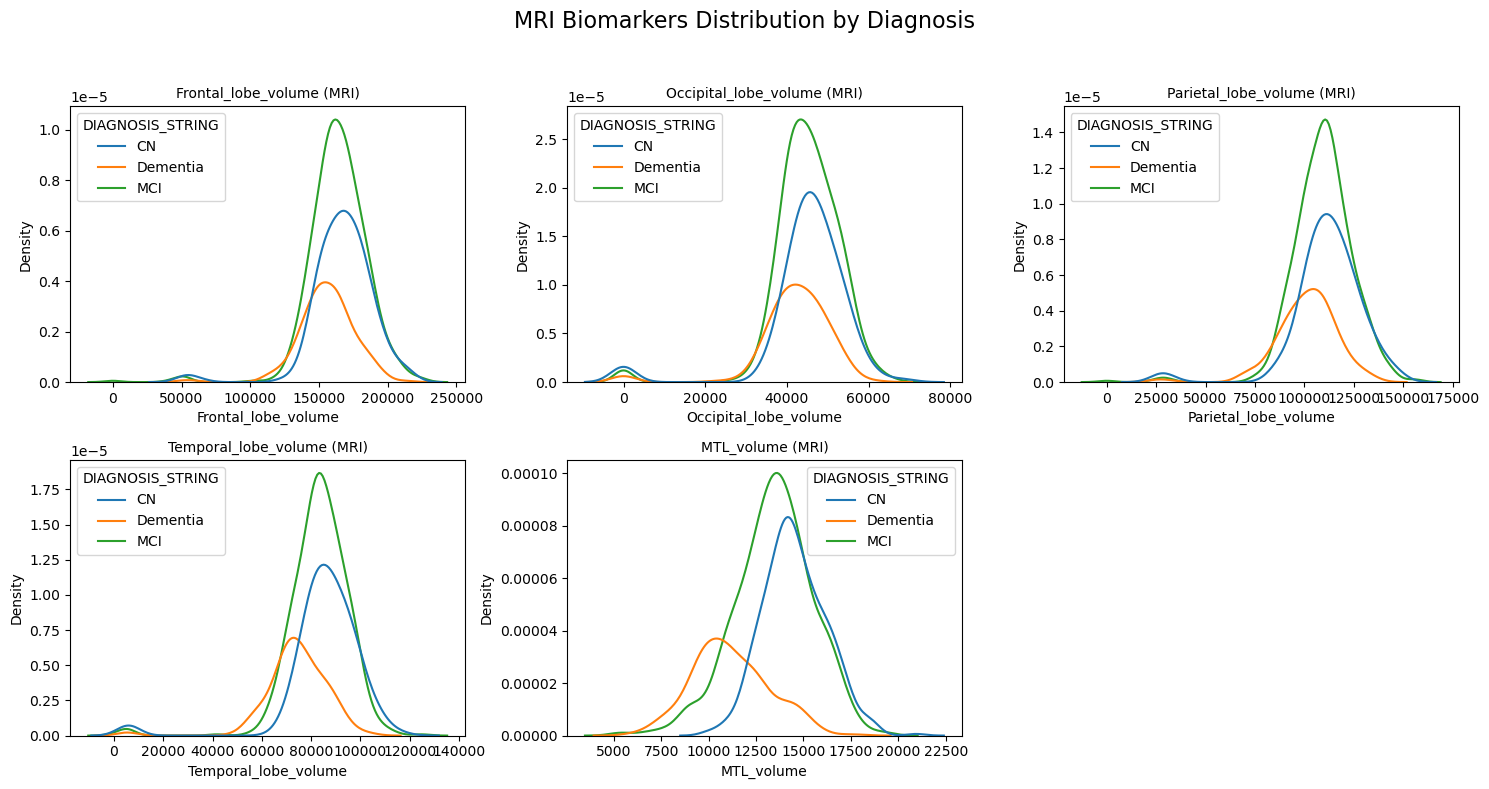

In [12]:
# Looking at the patient and control distribution for the biomarkers will help us understand which scale of biomarkers is relevant per modality

# Choose number of biomarkers per modality
biomarkers = biomarkers_mri  # change to biomarkers_ab / biomarkers_tau as needed
data = data_mri              # change accordingly
modality_label = "MRI"       # update per loop

# Plot config
n = len(biomarkers)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=data, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} ({modality_label})", fontsize=10)

# Turn off any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle(f"{modality_label} Biomarkers Distribution by Diagnosis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



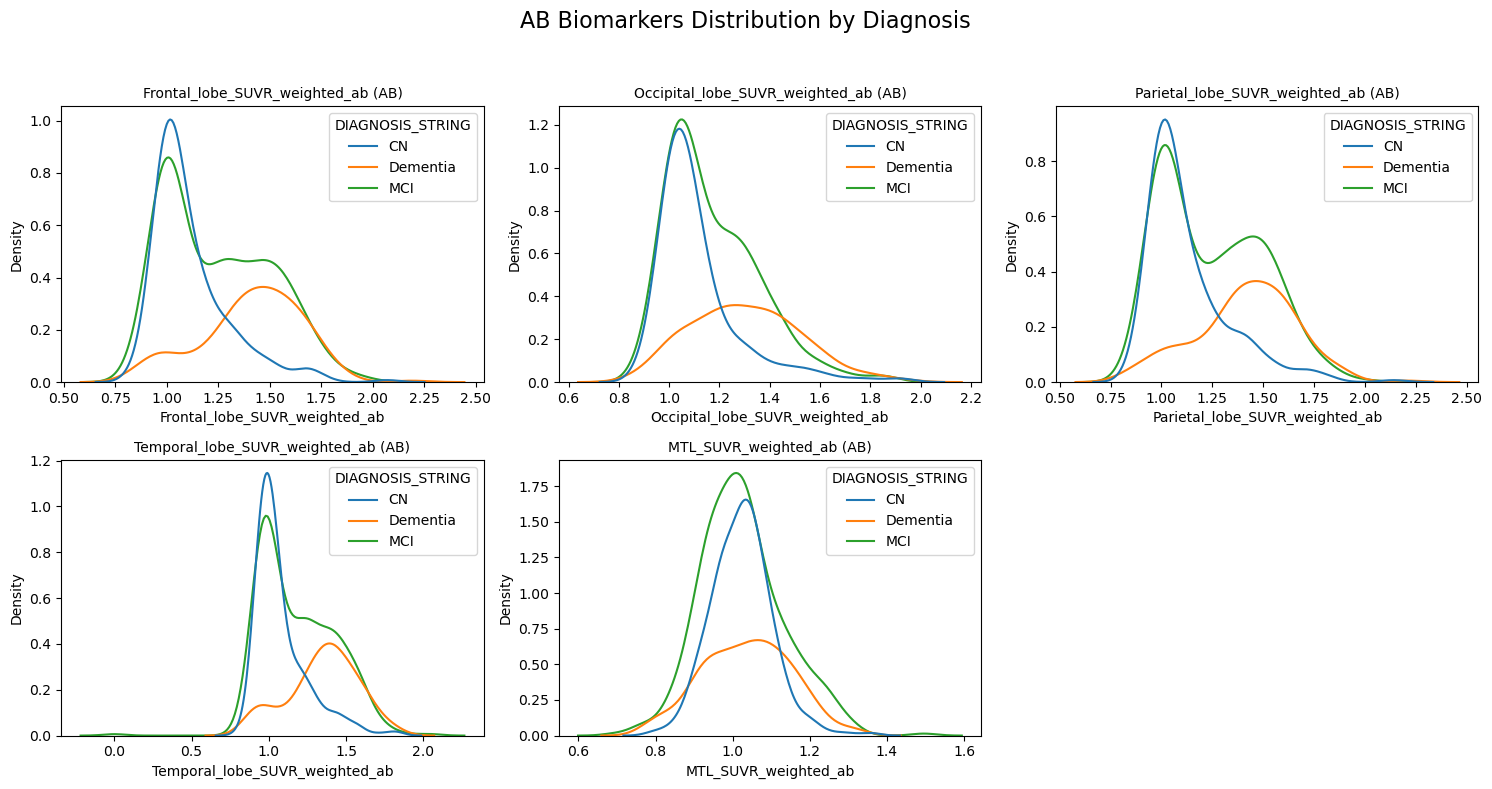

In [13]:
# Looking at the patient and control distribution for the biomarkers will help us understand which scale of biomarkers is relevant per modality

# Choose number of biomarkers per modality
biomarkers = biomarkers_ab  
data = data_ab              
modality_label = "AB"       

# Plot config
n = len(biomarkers)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=data, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} ({modality_label})", fontsize=10)

# Turn off any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle(f"{modality_label} Biomarkers Distribution by Diagnosis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



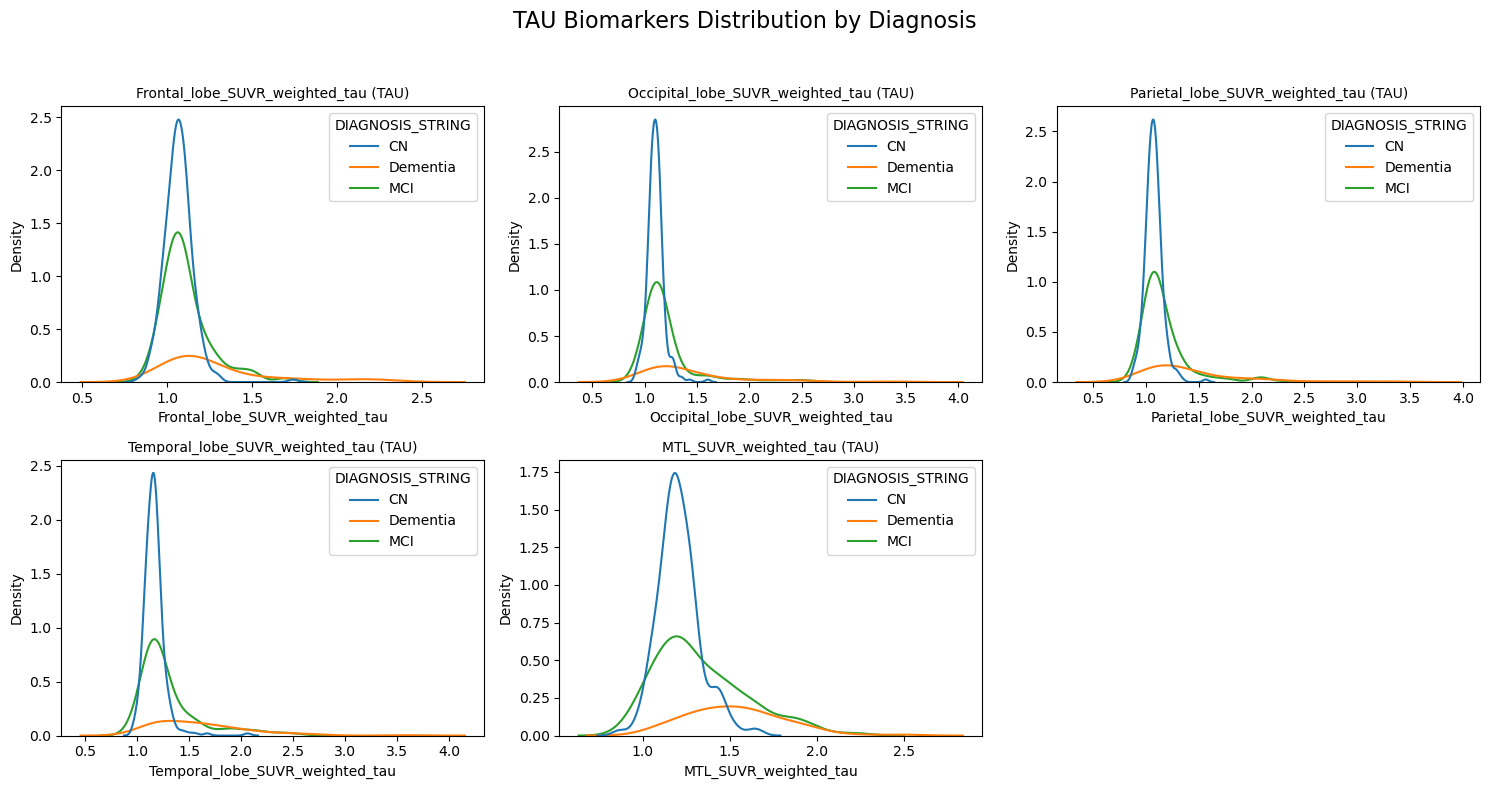

In [14]:
# Looking at the patient and control distribution for the biomarkers will help us understand which scale of biomarkers is relevant per modality

# Choose number of biomarkers per modality
biomarkers = biomarkers_tau  
data = data_tau              
modality_label = "TAU"       

# Plot config
n = len(biomarkers)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=data, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} ({modality_label})", fontsize=10)

# Turn off any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle(f"{modality_label} Biomarkers Distribution by Diagnosis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# n = len(biomarkers)
# cols = min(n, 3)                   # use up to 3 columns
# rows = math.ceil(n / cols)

# fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)
# axs = axs.flatten()                # flatten to 1D array

# for i, biomarker in enumerate(biomarkers):
#     ax = axs[i]
#     sns.kdeplot(data=data, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
#     ax.set_title(f"{biomarker} ({modality_label})", fontsize=10)

# # remove any extra axes
# for ax in axs[n:]:
#     fig.delaxes(ax)

# plt.suptitle(f"{modality_label} Biomarkers Distribution by Diagnosis", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()



In [15]:
#Decision for normalisation
# Ensure gender is treated as categorical
data_mri["PTGENDER"] = data_mri["PTGENDER"].astype("category")

# Run Type II ANOVA for each biomarker
anova_summary_mri = []

for biomarker in biomarkers_mri:
    formula = f"{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)"
    model = smf.ols(formula, data=data_mri).fit()
    
    anova_table = anova_lm(model, typ=2)  # Type II ANOVA
    
    # Collect p-values for each variable
    row = {
        "Biomarker": biomarker,
        "Age_pval": anova_table.loc["Age", "PR(>F)"],
        "ICV_pval": anova_table.loc["ICV_CorticalVolume", "PR(>F)"],
        "Gender_pval": anova_table.loc["C(PTGENDER)", "PR(>F)"]
    }
    anova_summary_mri.append(row)

# Convert to DataFrame for display
anova_results_mri = pd.DataFrame(anova_summary_mri)
print(anova_results_mri)


               Biomarker      Age_pval      ICV_pval   Gender_pval
0    Frontal_lobe_volume  1.222411e-15  1.220018e-18  7.911117e-29
1  Occipital_lobe_volume  9.449329e-05  2.064923e-09  5.067503e-13
2   Parietal_lobe_volume  1.686918e-13  8.710881e-19  1.486079e-18
3   Temporal_lobe_volume  1.138109e-08  4.763771e-11  1.021844e-16
4             MTL_volume  2.706618e-43  1.983307e-06  4.989968e-24


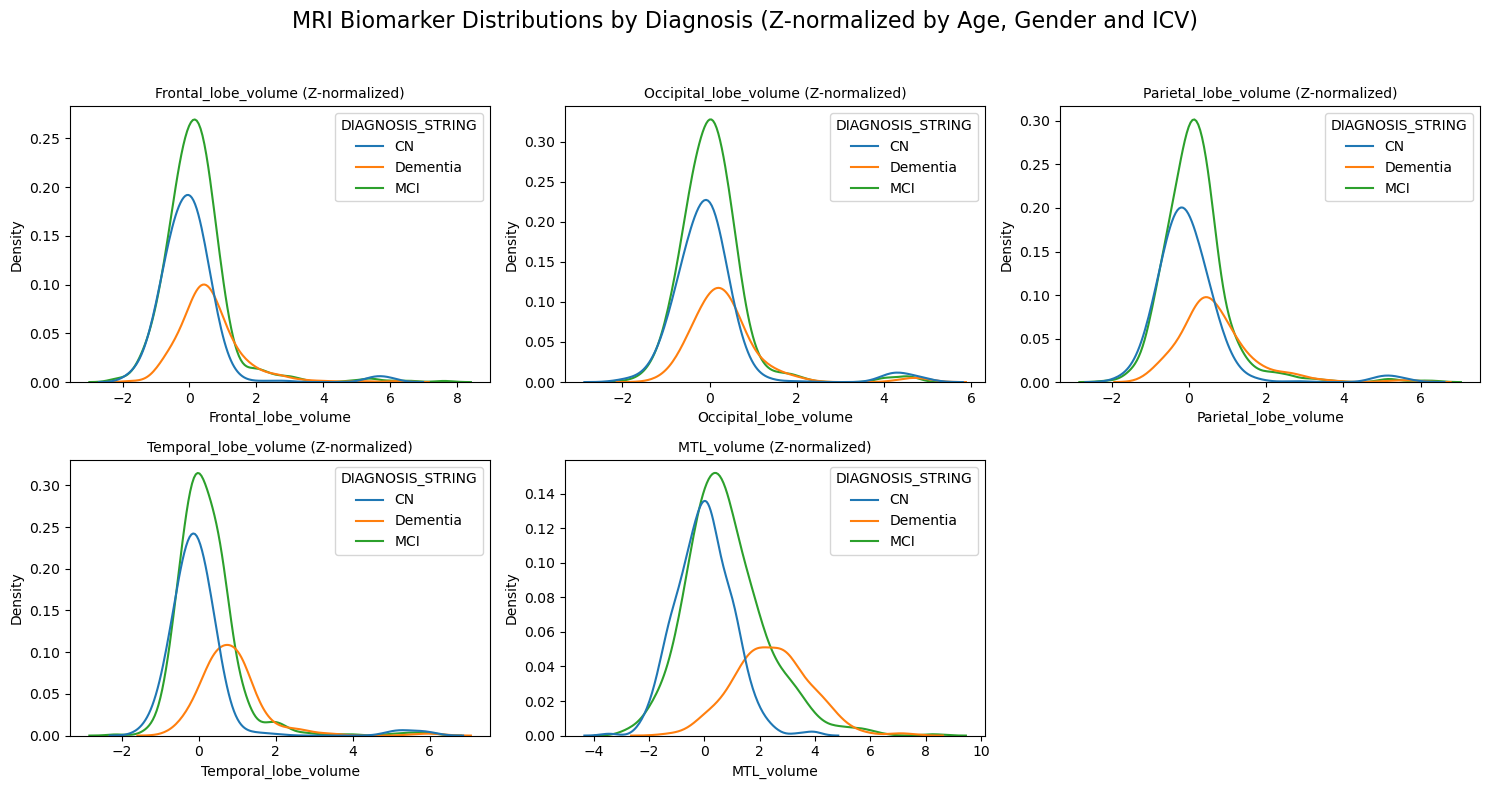

In [16]:
#Normalisation of the MRI data 

# Make a copy of data_mri to store normalized values
zdata_mri = pd.DataFrame(data_mri.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_mri: 
    model = smf.wls(f'{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)', data=data_mri[data_mri['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_mri[['Age', 'ICV_CorticalVolume', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_mri[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_mri['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_mri['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_mri[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_mri)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_mri):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_mri, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("MRI Biomarker Distributions by Diagnosis (Z-normalized by Age, Gender and ICV)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [17]:
# Ensure gender is treated as categorical
data_ab["PTGENDER"] = data_ab["PTGENDER"].astype("category")

# Run Type II ANOVA for each biomarker
anova_summary_ab = []

for biomarker in biomarkers_ab:
    formula = f"{biomarker} ~ Age + C(PTGENDER)"
    model = smf.ols(formula, data=data_ab).fit()
    
    anova_table = anova_lm(model, typ=2)  # Type II ANOVA
    
    # Collect p-values for each variable
    row = {
        "Biomarker": biomarker,
        "Age_pval": anova_table.loc["Age", "PR(>F)"],
        "Gender_pval": anova_table.loc["C(PTGENDER)", "PR(>F)"]
    }
    anova_summary_ab.append(row)

# Convert to DataFrame for display
anova_results_ab = pd.DataFrame(anova_summary_ab)
print(anova_results_ab)



                         Biomarker  Age_pval  Gender_pval
0    Frontal_lobe_SUVR_weighted_ab  0.000053     0.124046
1  Occipital_lobe_SUVR_weighted_ab  0.000671     0.000181
2   Parietal_lobe_SUVR_weighted_ab  0.000150     0.048953
3   Temporal_lobe_SUVR_weighted_ab  0.000631     0.013799
4             MTL_SUVR_weighted_ab  0.000232     0.009148


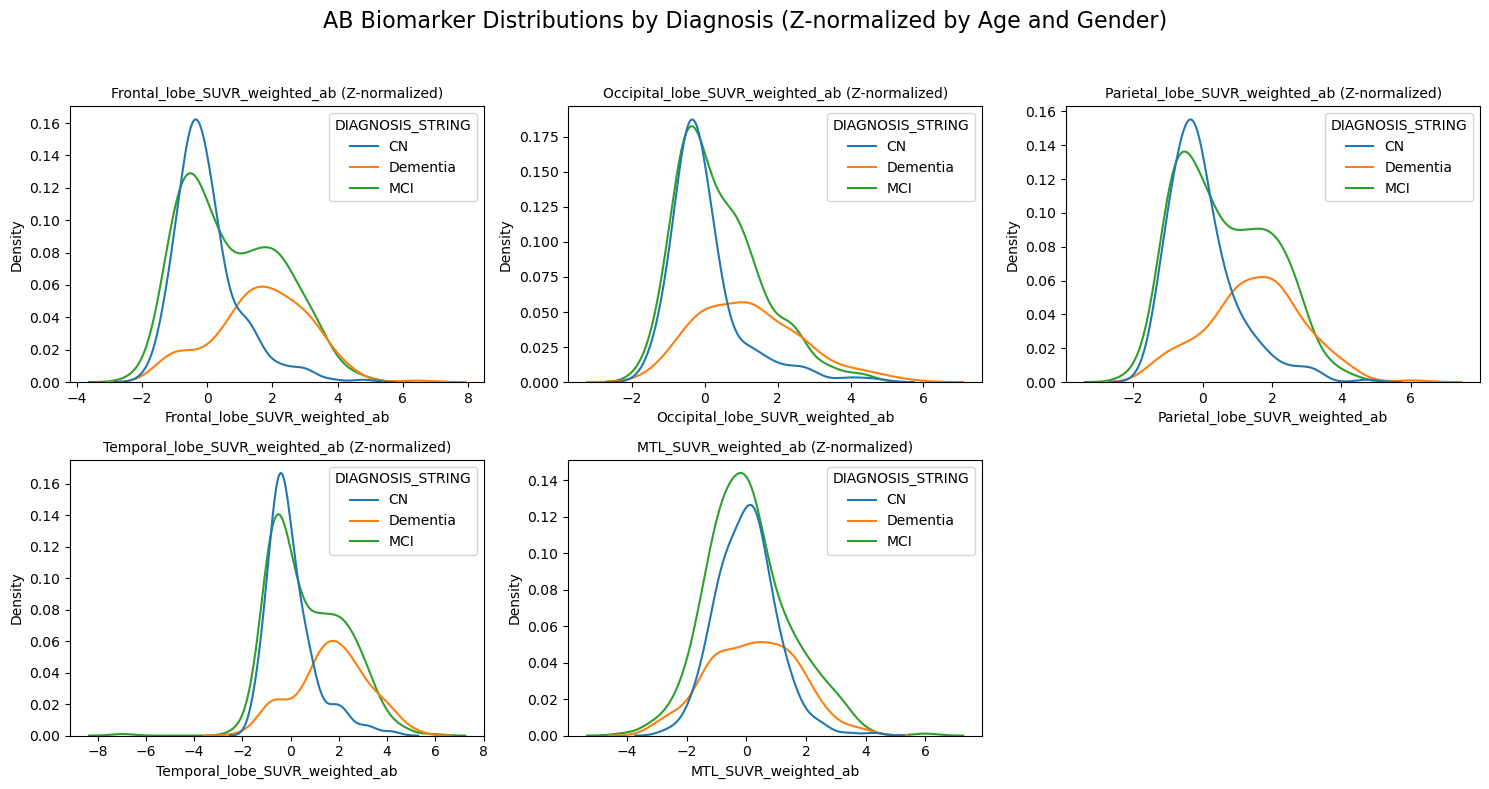

In [18]:
#Normalisation of the AB data 

# Make a copy of data_ab to store normalized values
zdata_ab = pd.DataFrame(data_ab.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_ab: 
    model = smf.wls(f'{biomarker} ~ Age + PTGENDER', data=data_ab[data_ab['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_ab[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_ab[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_ab['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_ab['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_ab[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_ab):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_ab, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("AB Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [19]:
# Ensure gender is treated as categorical
data_tau["PTGENDER"] = data_tau["PTGENDER"].astype("category")

# Run Type II ANOVA for each biomarker
anova_summary_tau = []

for biomarker in biomarkers_tau:
    formula = f"{biomarker} ~ Age + C(PTGENDER)"
    model = smf.ols(formula, data=data_tau).fit()
    
    anova_table = anova_lm(model, typ=2)  # Type II ANOVA
    
    # Collect p-values for each variable
    row = {
        "Biomarker": biomarker,
        "Age_pval": anova_table.loc["Age", "PR(>F)"],
        "Gender_pval": anova_table.loc["C(PTGENDER)", "PR(>F)"]
    }
    anova_summary_tau.append(row)

# Convert to DataFrame for display
anova_results_tau = pd.DataFrame(anova_summary_tau)
print(anova_results_tau)



                          Biomarker  Age_pval  Gender_pval
0    Frontal_lobe_SUVR_weighted_tau  0.084452     0.174633
1  Occipital_lobe_SUVR_weighted_tau  0.180915     0.189712
2   Parietal_lobe_SUVR_weighted_tau  0.010590     0.712452
3   Temporal_lobe_SUVR_weighted_tau  0.703071     0.127681
4             MTL_SUVR_weighted_tau  0.008708     0.117736


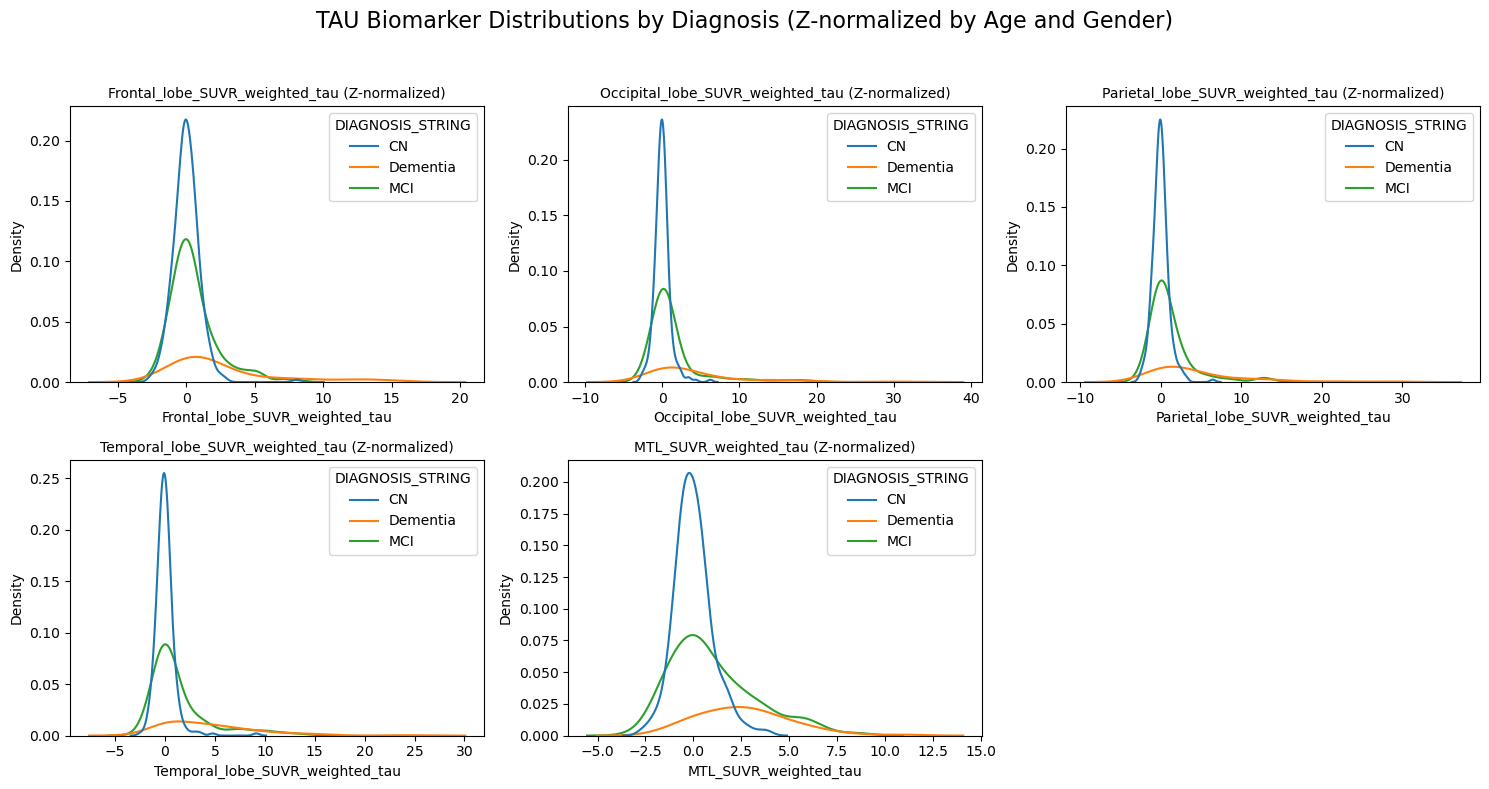

                         Biomarker  Age_pval  Gender_pval
0    Frontal_lobe_SUVR_weighted_ab  0.000053     0.124046
1  Occipital_lobe_SUVR_weighted_ab  0.000671     0.000181
2   Parietal_lobe_SUVR_weighted_ab  0.000150     0.048953
3   Temporal_lobe_SUVR_weighted_ab  0.000631     0.013799
4             MTL_SUVR_weighted_ab  0.000232     0.009148


In [20]:
#Normalisation of the TAU data 

# Make a copy of data_tau to store normalized values
zdata_tau = pd.DataFrame(data_tau.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_tau: 
    model = smf.wls(f'{biomarker} ~ Age + PTGENDER', data=data_tau[data_tau['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_tau[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_tau[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_tau['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_tau['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_tau[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_tau):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_tau, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("TAU Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Ensure gender is treated as categorical
data_ab["PTGENDER"] = data_ab["PTGENDER"].astype("category")

# Run Type II ANOVA for each biomarker
anova_summary_ab = []

for biomarker in biomarkers_ab:
    formula = f"{biomarker} ~ Age + C(PTGENDER)"
    model = smf.ols(formula, data=data_ab).fit()
    
    anova_table = anova_lm(model, typ=2)  # Type II ANOVA
    
    # Collect p-values for each variable
    row = {
        "Biomarker": biomarker,
        "Age_pval": anova_table.loc["Age", "PR(>F)"],
        "Gender_pval": anova_table.loc["C(PTGENDER)", "PR(>F)"]
    }
    anova_summary_ab.append(row)

# Convert to DataFrame for display
anova_results_ab = pd.DataFrame(anova_summary_ab)
print(anova_results_ab)



Now that we've normalized the data, let's look at the new distribution and make sure it looks right

## Prepare SuStaIn inputs

Now that we've z-scored our data, let's start prepping the many SuStaIn inputs

In [21]:
N_mri = len(biomarkers_mri)         # number of biomarkers
SuStaInLabels_mri = biomarkers_mri
print(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0))
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score
print(Z_max_mri)

N_ab = len(biomarkers_ab)         # number of biomarkers
SuStaInLabels_ab = biomarkers_ab
print(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0))
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
print(Z_max_ab)

N_tau = len(biomarkers_tau)         # number of biomarkers
SuStaInLabels_tau = biomarkers_tau
print(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0))
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score
print(Z_max_tau)


[5.34018685 4.52258089 5.09787365 5.30281073 5.02343377]
[6 5 6 6 6]
[4.23719898 4.32938871 3.99426607 4.37132776 3.50817006]
[5 5 4 5 4]
[11.01623384 18.29460437 14.86366218 12.92731404  6.93401361]
[12 19 15 13  7]


In [22]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 50
N_S_max_mri = 4
N_S_max_ab = 2
N_S_max_tau = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'

# Initiate the SuStaIn object
sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)

sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)

sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)

In [23]:
# if the files already exist and I want to delete the previous ones to replace with new results
if os.path.exists(output_folder_mri):
    shutil.rmtree(output_folder_mri)

# make the output directory if it's not already created
if not os.path.isdir(output_folder_mri):
    os.mkdir(output_folder_mri)


In [24]:
# if the files already exist and I want to delete the previous ones to replace with new results
if os.path.exists(output_folder_ab):
    shutil.rmtree(output_folder_ab)

# make the output directory if it's not already created
if not os.path.isdir(output_folder_ab):
    os.mkdir(output_folder_ab)


In [25]:
# if the files already exist and I want to delete the previous ones to replace with new results
if os.path.exists(output_folder_tau):
    shutil.rmtree(output_folder_tau)

# make the output directory if it's not already created
if not os.path.isdir(output_folder_tau):
    os.mkdir(output_folder_tau)


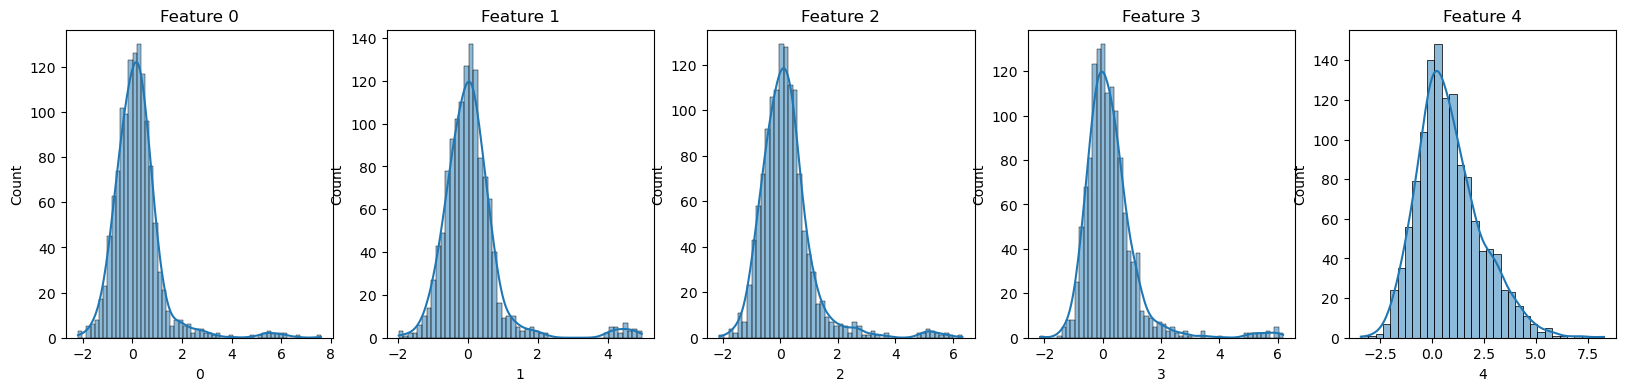

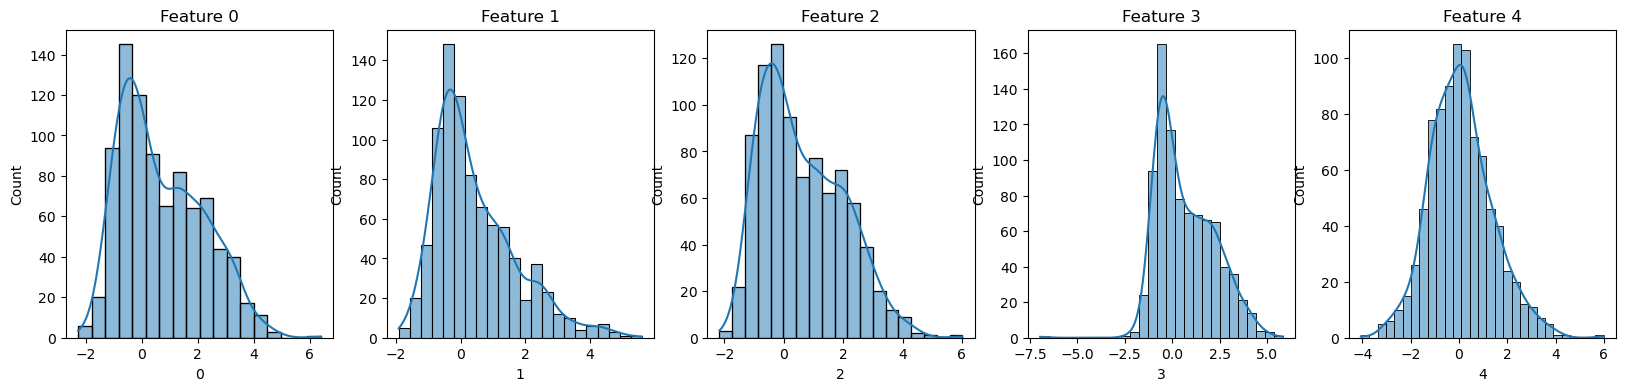

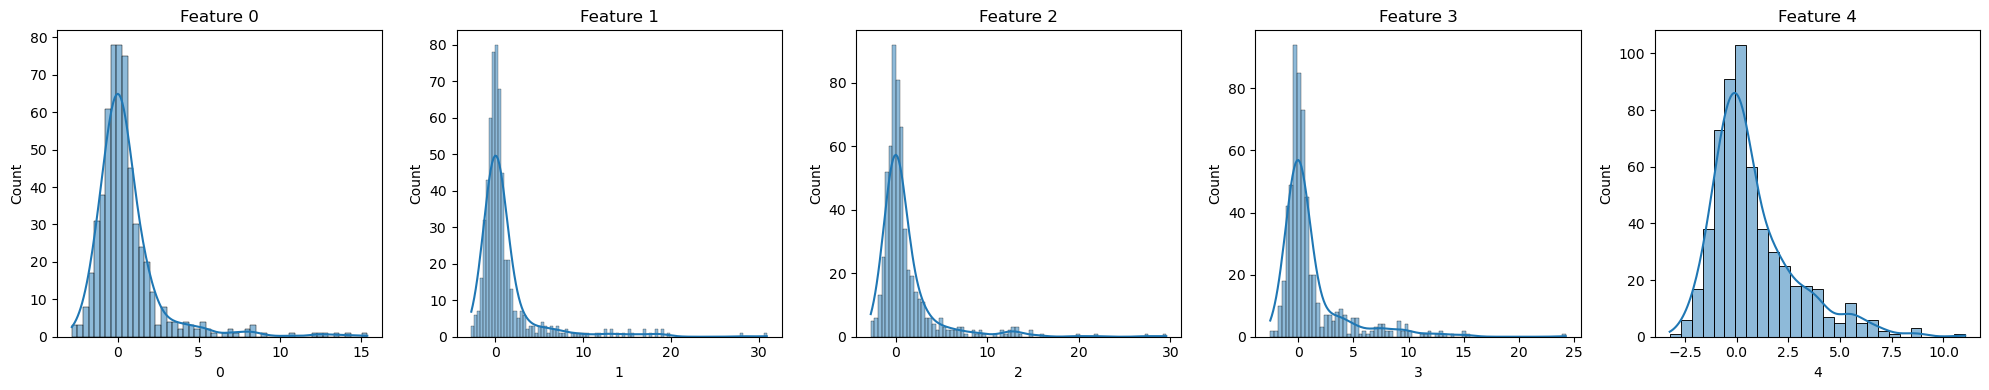

In [26]:
data_matrix = pd.DataFrame(sustain_input_mri._ZscoreSustain__sustainData.data)
fig, axes = plt.subplots(1, len(data_matrix.columns), figsize=(4 * len(data_matrix.columns), 4))
for i, col in enumerate(data_matrix.columns):
    sns.histplot(data_matrix[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Feature {i}')


data_matrix = pd.DataFrame(sustain_input_ab._ZscoreSustain__sustainData.data)
fig, axes = plt.subplots(1, len(data_matrix.columns), figsize=(4 * len(data_matrix.columns), 4))
for i, col in enumerate(data_matrix.columns):
    sns.histplot(data_matrix[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Feature {i}')


data_matrix = pd.DataFrame(sustain_input_tau._ZscoreSustain__sustainData.data)
fig, axes = plt.subplots(1, len(data_matrix.columns), figsize=(4 * len(data_matrix.columns), 4))
for i, col in enumerate(data_matrix.columns):
    sns.histplot(data_matrix[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

In [27]:
samples_sequence_mri,   \
samples_f_mri,          \
ml_subtype_mri,         \
prob_ml_subtype_mri,    \
ml_stage_mri,           \
prob_ml_stage_mri,      \
prob_subtype_stage_mri  = sustain_input_mri.run_sustain_algorithm()

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/MRIOutput/pickle_files/MRIOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -11523.945321414645


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/MRIOutput/pickle_files/MRIOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11330.16812051]
Overall ML likelihood is [-11330.16812051]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/MRIOutput/pickle_files/MRIOutput_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11215.19586077]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11215.19595106]
Overall ML likelihood is [-11215.19586077]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/MRIOutput/pickle_files/MRIOutput_subtype3.pickle. Running SuStaIn model for 3 subtype.
Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11175.3367428]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11208.93128623]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-11172.26428874]
Overall ML likelihood is [-11172.26428874]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

In [28]:
samples_sequence_ab,   \
samples_f_ab,          \
ml_subtype_ab,         \
prob_ml_subtype_ab,    \
ml_stage_ab,           \
prob_ml_stage_ab,      \
prob_subtype_stage_ab  = sustain_input_ab.run_sustain_algorithm()

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -7192.4165560405545


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7173.45121477]
Overall ML likelihood is [-7173.45121477]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

In [29]:
samples_sequence_tau,   \
samples_f_tau,          \
ml_subtype_tau,         \
prob_ml_subtype_tau,    \
ml_stage_tau,           \
prob_ml_stage_tau,      \
prob_subtype_stage_tau  = sustain_input_tau.run_sustain_algorithm()

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/TAUOutput/pickle_files/TAUOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -7603.6878201788


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/TAUOutput/pickle_files/TAUOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6979.61593393]
Overall ML likelihood is [-6979.61593393]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/TAUOutput/pickle_files/TAUOutput_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6938.43770899]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6846.85330085]
Overall ML likelihood is [-6846.85330085]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/TAUOutput/pickle_files/TAUOutput_subtype3.pickle. Running SuStaIn model for 3 subtype.
Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6809.06776099]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6778.91849197]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6774.96093149]
Overall ML likelihood is [-6774.96093149]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

## Evaluate subtypes

Here, we'll plot the log likelihood across MCMC samples, across each subtype. This will give us at least a basic sense of what how many subtypes we should consider looking at

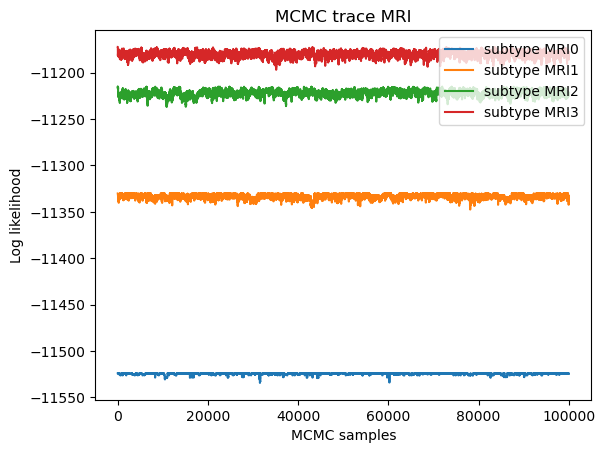

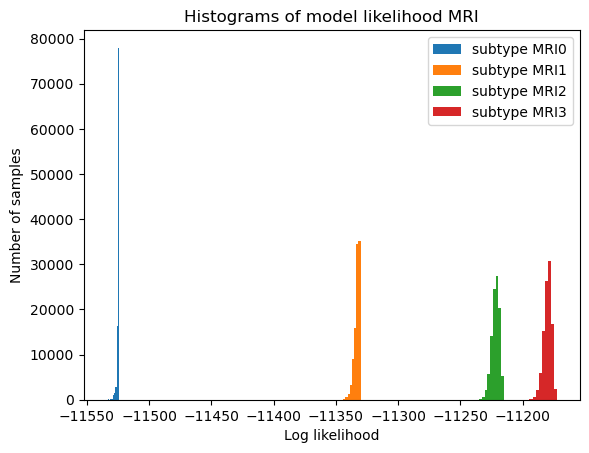

In [30]:
# for each MRI subtype model
for s in range(N_S_max_mri):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(s) + '.pickle'
    pk_mri = pd.read_pickle(pickle_filename_s_mri)
    samples_likelihood_mri = pk_mri["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood_mri, label="subtype MRI" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace MRI')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood_mri, label="subtype MRI" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood MRI')

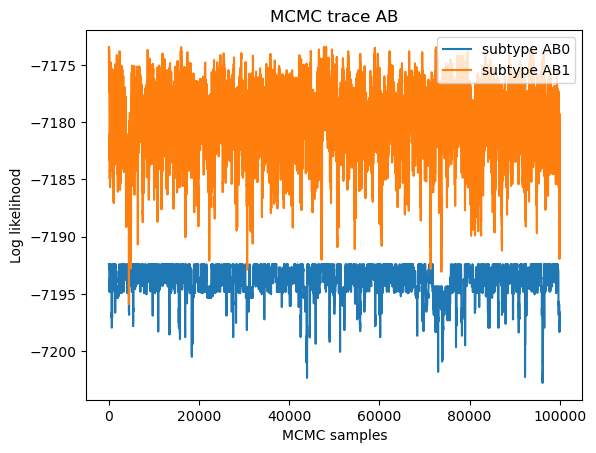

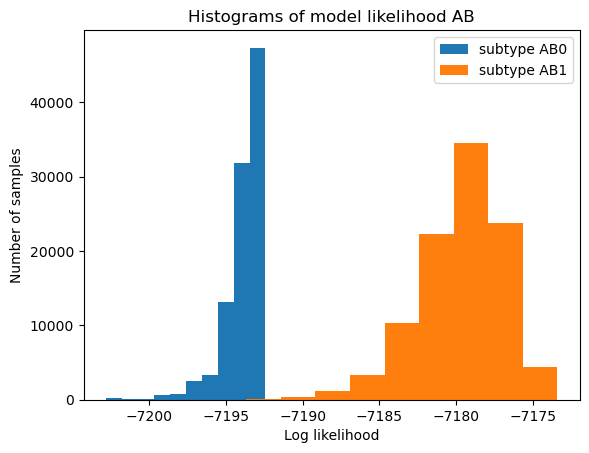

In [31]:
# for each AB subtype model
for s in range(N_S_max_ab):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(s) + '.pickle'
    pk_ab = pd.read_pickle(pickle_filename_s_ab)
    samples_likelihood_ab = pk_ab["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood_ab, label="subtype AB" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace AB')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood_ab, label="subtype AB" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood AB')

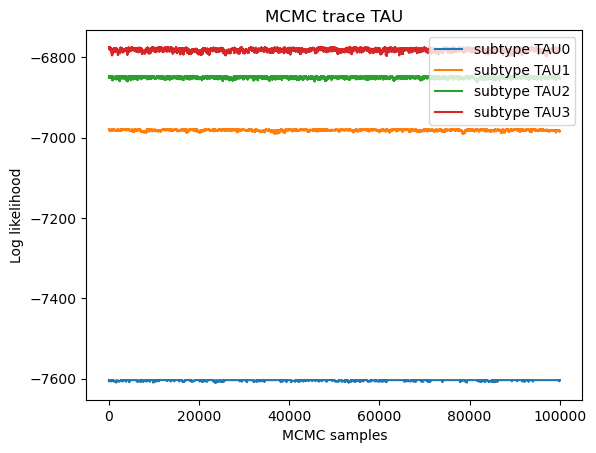

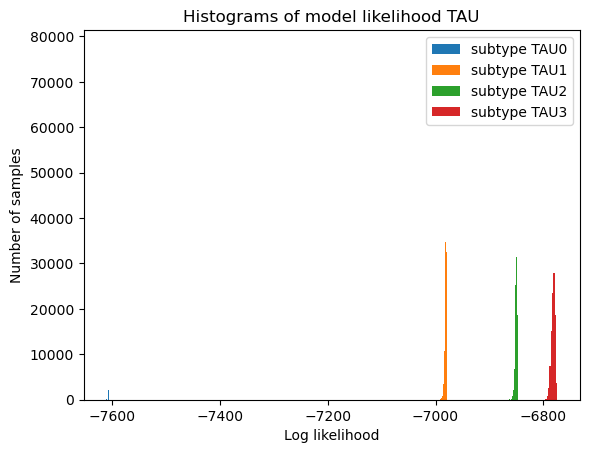

In [32]:
# for each TAU subtype model
for s in range(N_S_max_tau):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(s) + '.pickle'
    pk_tau = pd.read_pickle(pickle_filename_s_tau)
    samples_likelihood_tau = pk_tau["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood_tau, label="subtype TAU" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace TAU')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood_tau, label="subtype TAU" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood TAU')

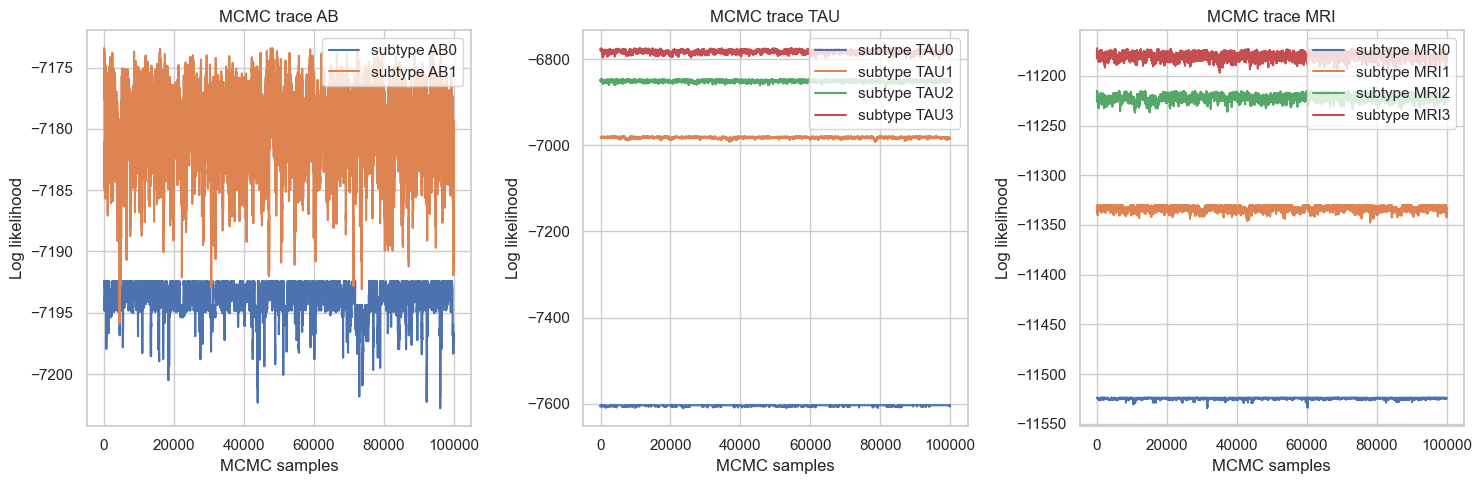

In [95]:
# 1 row × 3 columns subplot layout
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)

# Order: AB (left), TAU (middle), MRI (right)
modality_info = [
    ("AB", N_S_max_ab, output_folder_ab, dataset_name_ab),
    ("TAU", N_S_max_tau, output_folder_tau, dataset_name_tau),
    ("MRI", N_S_max_mri, output_folder_mri, dataset_name_mri)
]

for col, (mod, N_S_max, output_folder, dataset_name) in enumerate(modality_info):
    all_samples_modality = []

    for s in range(N_S_max):
        pickle_filename = f"{output_folder}/pickle_files/{dataset_name}_subtype{s}.pickle"
        pk = pd.read_pickle(pickle_filename)
        samples_likelihood = pk["samples_likelihood"]

        all_samples_modality.extend(samples_likelihood)

        # Plot MCMC trace
        axes[col].plot(range(len(samples_likelihood)), samples_likelihood, label=f"subtype {mod}{s}")

    # Set independent y-limits with margin
    ymin, ymax = min(all_samples_modality), max(all_samples_modality)
    margin = 0.05 * (ymax - ymin) if ymax != ymin else 1
    axes[col].set_ylim(ymin - margin, ymax + margin)

    # Formatting
    axes[col].set_title(f"MCMC trace {mod}")
    axes[col].set_xlabel("MCMC samples")
    axes[col].set_ylabel("Log likelihood")
    axes[col].legend(loc="upper right")

plt.tight_layout()

# Save figure
plt.savefig("mcmc_traces_1x3.png", dpi=300, bbox_inches="tight")
plt.show()


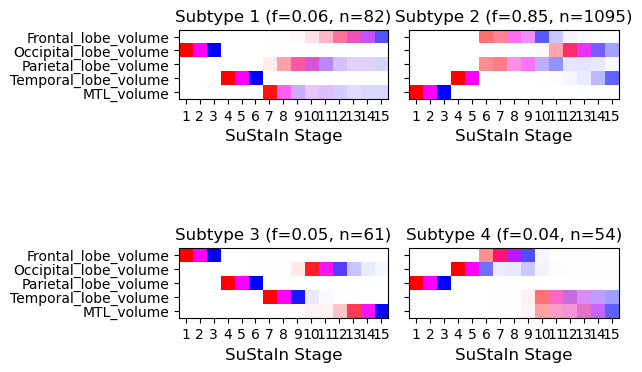

In [33]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 3 # 1 split = 2 subtypes
M = len(zdata_mri) 

# get the sample sequences and f
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(s) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]
biomarker_labels_mri = ['Frontal_lobe_volume', 'Occipital_lobe_volume',
                        'Parietal_lobe_volume', 'Temporal_lobe_volume', 'MTL_volume']

# use this information to plot the positional variance diagrams
tmp_mri=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_mri,samples_sequence_mri,samples_f_mri,M,subtype_order=(0,1,2,3), biomarker_labels=biomarker_labels_mri)



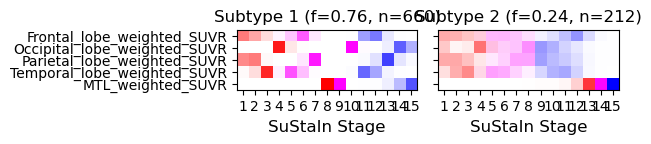

In [34]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata_ab) 

# get the sample sequences and f
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(s) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]
biomarker_labels_pet = ['Frontal_lobe_weighted_SUVR', 'Occipital_lobe_weighted_SUVR',
                        'Parietal_lobe_weighted_SUVR', 'Temporal_lobe_weighted_SUVR', 'MTL_weighted_SUVR']

# use this information to plot the positional variance diagrams
tmp_ab=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_ab,samples_sequence_ab,samples_f_ab,M,subtype_order=(0,1), biomarker_labels=biomarker_labels_pet)



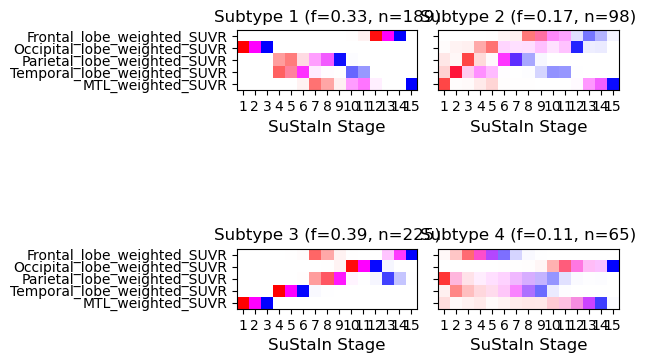

In [35]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 3 # 1 split = 2 subtypes
M = len(zdata_tau) 

# get the sample sequences and f
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(s) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

# use this information to plot the positional variance diagrams
tmp_tau=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_tau,samples_sequence_tau,samples_f_tau,M,subtype_order=(0,1,2,3), biomarker_labels=biomarker_labels_pet)



/var/folders/nl/7qp9kcyn5c965d6fjctkjyd00000gn/T/ipykernel_5408/1881921770.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


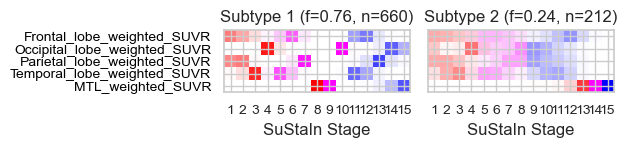

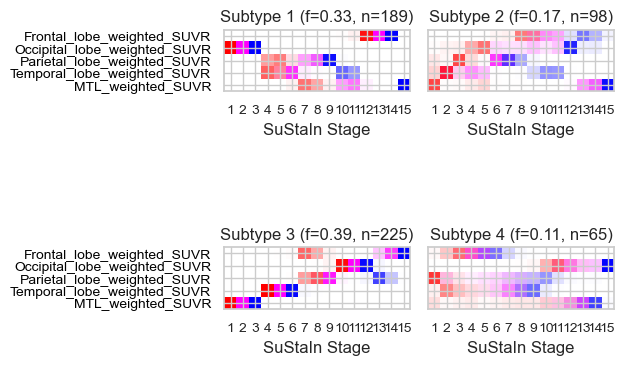

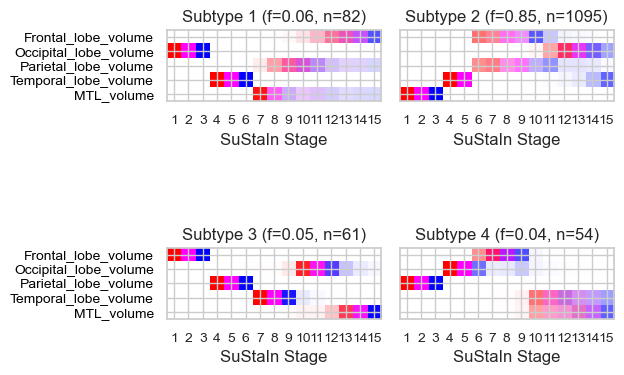

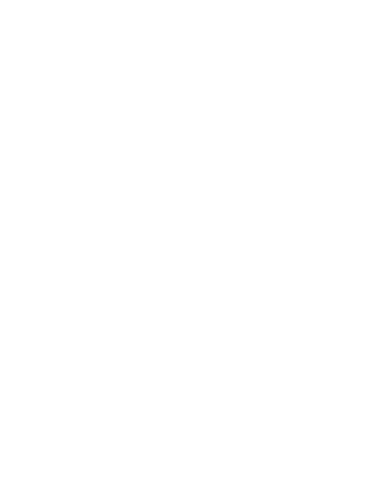

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import matplotlib.gridspec as gridspec

def render_pvd_to_image(sustain_input, pickle_path, M, subtype_order, biomarker_labels, figsize=(8,4)):
    """
    Render pySuStaIn.ZscoreSustain._plot_sustain_model into a numpy RGB image array,
    and remove any '(n=...)' pieces from subplot titles.
    """
    # load pickle (samples_sequence, samples_f are inside)
    pk = pd.read_pickle(pickle_path)

    # open a temporary figure and let pySuStaIn draw into it
    fig_tmp = plt.figure(figsize=figsize)
    pySuStaIn.ZscoreSustain._plot_sustain_model(
        sustain_input,
        pk["samples_sequence"],
        pk["samples_f"],
        M,
        subtype_order=subtype_order,
        biomarker_labels=biomarker_labels
    )

    # # remove "(n=...)" from any axis titles created by the function
    # for ax in plt.gcf().axes:
    #     title = ax.get_title()
    #     new_title = re.sub(r"\s*\(n=.*?\)", "", title)    # removes (n=123) or similar
    #     ax.set_title(new_title)

    # render the figure to an RGB numpy array
    fig_tmp.canvas.draw()
    w, h = fig_tmp.canvas.get_width_height()
    img = np.frombuffer(fig_tmp.canvas.tostring_rgb(), dtype='uint8').reshape(h, w, 3)

    # close the temp figure to free resources
    plt.close(fig_tmp)
    return img

# --- Render each modality to an image (AB, TAU, MRI order) ---
img_ab  = render_pvd_to_image(
    sustain_input_ab,
    f"{output_folder_ab}/pickle_files/{dataset_name_ab}_subtype1.pickle",
    len(zdata_ab),
    subtype_order=(0,1),
    biomarker_labels=biomarker_labels_pet,
    figsize=(10, 3.5)   # tweak per-modality figsize if you like
)

img_tau = render_pvd_to_image(
    sustain_input_tau,
    f"{output_folder_tau}/pickle_files/{dataset_name_tau}_subtype3.pickle",
    len(zdata_tau),
    subtype_order=(0,1,2,3),
    biomarker_labels=biomarker_labels_pet,
    figsize=(10, 4.0)
)

img_mri = render_pvd_to_image(
    sustain_input_mri,
    f"{output_folder_mri}/pickle_files/{dataset_name_mri}_subtype3.pickle",
    len(zdata_mri),
    subtype_order=(0,1,2,3),
    biomarker_labels=biomarker_labels_mri,
    figsize=(10, 4.0)
)

# --- Compose the three images into one vertical figure ---
images = [img_ab, img_tau, img_mri]
labels = ["AB", "TAU", "MRI"]
height_ratios = [im.shape[0] for im in images]  # preserve relative vertical sizes

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=height_ratios, hspace=0.15)

for i, im in enumerate(images):
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(im)
    ax.axis("off")
   
    
plt.tight_layout()
outpath = "positional_variance_AB_TAU_MRI.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()


## Subtype and stage individuals

In [36]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk_mri.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [37]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk_ab.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [38]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk_tau.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [39]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 3
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(s) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata_mri.loc[:,variable] = pk_mri[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata_mri.loc[:,'prob_S%s'%i] = pk_mri['prob_subtype'][:,i]
zdata_mri.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2010-12-21               CN        1.0   91     26.0    0.0      14.0   
1   30  2007-11-13         Dementia        3.0  100     22.0    0.0      19.0   
2   72  2019-10-16               CN        1.0   90     28.0    0.0      16.0   
3   74  2021-01-11               CN        1.0   98     29.0    0.0      20.0   
4   86  2006-05-08               CN        1.0  100      0.0    0.0      18.0   

  PTGENDER  AGE_RETIRE  ...  Temporal_lobe_Asymmetry_MRI_R  \
0      1.0        76.0  ...                         0.0272   
1      2.0        59.0  ...                        -0.0664   
2      1.0         0.0  ...                        -0.0257   
3      1.0        74.0  ...                        -0.0171   
4      2.0        66.0  ...                        -0.0070   

   MTL_Asymmetry_MRI_L  MTL_Asymmetry_MRI_R  ml_subtype  prob_ml_subtype  \
0              -0.0410               0.0410         0.0         0.645338   
1               0.0061              -0.0061         0.0         0.999489   
2              -0.0295               0.0295         0.0         0.748911   
3               0.0618              -0.0618         0.0         0.999795   
4               0.0647              -0.0647         0.0         0.845885   

   ml_stage  prob_ml_stage   prob_S0   prob_S1   prob_S2  
0       0.0       0.086658  0.645338  0.110223  0.032885  
1       1.0       0.426227  0.999489  0.000147  0.000256  
2       0.0       0.143419  0.748911  0.066094  0.121897  
3       2.0       0.425670  0.999795  0.000042  0.000125  
4       0.0       0.242128  0.845885  0.063910  0.058784  

[5 rows x 33 columns]

In [40]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(s) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata_ab.loc[:,variable] = pk_ab[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata_ab.loc[:,'prob_S%s'%i] = pk_ab['prob_subtype'][:,i]
zdata_ab.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2012-12-27               CN        1.0   91     28.0    0.0      14.0   
1   42  2011-04-13         Dementia        3.0   93     23.0    0.0      18.0   
2   58  2011-04-27               CN        1.0   90     29.0    1.0      16.0   
3   61  2013-02-06              MCI        2.0   97     25.0    0.0      15.0   
4   74  2012-12-11               CN        1.0   98     30.0    0.0      20.0   

  PTGENDER  AGE_RETIRE  ...  Parietal_lobe_Asymmetry_ab_R  \
0      1.0        55.0  ...                        0.0685   
1      1.0        55.0  ...                       -0.0098   
2      1.0         0.0  ...                        0.0073   
3      2.0        62.0  ...                       -0.0174   
4      1.0        74.0  ...                       -0.0033   

   Temporal_lobe_Asymmetry_ab_L  Temporal_lobe_Asymmetry_ab_R  \
0                       -0.0575                        0.0575   
1                       -0.0025                        0.0025   
2                       -0.0063                        0.0063   
3                        0.0382                       -0.0382   
4                       -0.0201                        0.0201   

   MTL_Asymmetry_ab_L  MTL_Asymmetry_ab_R  ml_subtype  prob_ml_subtype  \
0             -0.0083              0.0083         0.0         0.757280   
1             -0.0158              0.0158         0.0         0.744181   
2              0.0278             -0.0278         0.0         0.747803   
3              0.0284             -0.0284         0.0         0.769564   
4             -0.0162              0.0162         0.0         0.743888   

   ml_stage  prob_ml_stage   prob_S0  
0       0.0       0.192612  0.757280  
1       0.0       0.420652  0.744181  
2       0.0       0.420989  0.747803  
3       0.0       0.211044  0.769564  
4       0.0       0.338973  0.743888  

[5 rows x 30 columns]

In [41]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 3
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(s) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata_tau.loc[:,variable] = pk_tau[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata_tau.loc[:,'prob_S%s'%i] = pk_tau['prob_subtype'][:,i]
zdata_tau.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   96  2016-03-07               CN        1.0   99     29.0    0.0      20.0   
1  112  2016-02-05         Dementia        3.0   90     25.0    1.0      18.0   
2  205  2020-07-15               CN        1.0   86     30.0    0.0      18.0   
3  303  2016-04-27               CN        1.0  104     30.0    1.0      16.0   
4  420  2018-10-16              MCI        2.0   93     28.0    0.0      19.0   

  PTGENDER  AGE_RETIRE  ...  Temporal_lobe_Asymmetry_tau_R  \
0      1.0        67.0  ...                        -0.0040   
1      1.0        59.0  ...                         0.0110   
2      2.0        61.0  ...                        -0.0261   
3      1.0        61.0  ...                         0.0134   
4      1.0        78.0  ...                         0.0051   

   MTL_Asymmetry_tau_L  MTL_Asymmetry_tau_R  ml_subtype  prob_ml_subtype  \
0               0.0183              -0.0183         1.0         0.548642   
1              -0.0364               0.0364         3.0         0.732568   
2              -0.0231               0.0231         0.0         0.555808   
3              -0.0055               0.0055         0.0         0.379709   
4               0.0113              -0.0113         0.0         0.603582   

   ml_stage  prob_ml_stage   prob_S0   prob_S1   prob_S2  
0       0.0       0.391306  0.168116  0.548642  0.078518  
1       3.0       0.414628  0.000117  0.000023  0.267292  
2       0.0       0.419803  0.555808  0.293960  0.073918  
3       0.0       0.219264  0.379709  0.268484  0.152602  
4       0.0       0.465993  0.603582  0.236943  0.121787  

[5 rows x 32 columns]

In [42]:
# # IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# # We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# # make current subtypes (0 and 1) 1 and 2 instead
# zdata_mri.loc[:,'ml_subtype'] = zdata_mri.ml_subtype.values + 1

# # convert "Stage 0" subjects to subtype 0
# zdata_mri.loc[zdata_mri.ml_stage==0,'ml_subtype'] = 0

In [43]:
# # IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# # We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# # make current subtypes (0 and 1) 1 and 2 instead
# zdata_ab.loc[:,'ml_subtype'] = zdata_ab.ml_subtype.values + 1

# # convert "Stage 0" subjects to subtype 0
# zdata_ab.loc[zdata_ab.ml_stage==0,'ml_subtype'] = 0

In [44]:
# # IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# # We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# # make current subtypes (0 and 1) 1 and 2 instead
# zdata_tau.loc[:,'ml_subtype'] = zdata_tau.ml_subtype.values + 1

# # convert "Stage 0" subjects to subtype 0
# zdata_tau.loc[zdata_tau.ml_stage==0,'ml_subtype'] = 0

In [45]:
zdata_mri.ml_subtype.value_counts()

ml_subtype
0.0    1249
1.0      21
2.0      12
3.0      11
Name: count, dtype: int64

In [46]:
zdata_ab.ml_subtype.value_counts()

ml_subtype
0.0    850
1.0     22
Name: count, dtype: int64

In [47]:
zdata_tau.ml_subtype.value_counts()

ml_subtype
0.0    268
1.0    233
2.0     52
3.0     24
Name: count, dtype: int64

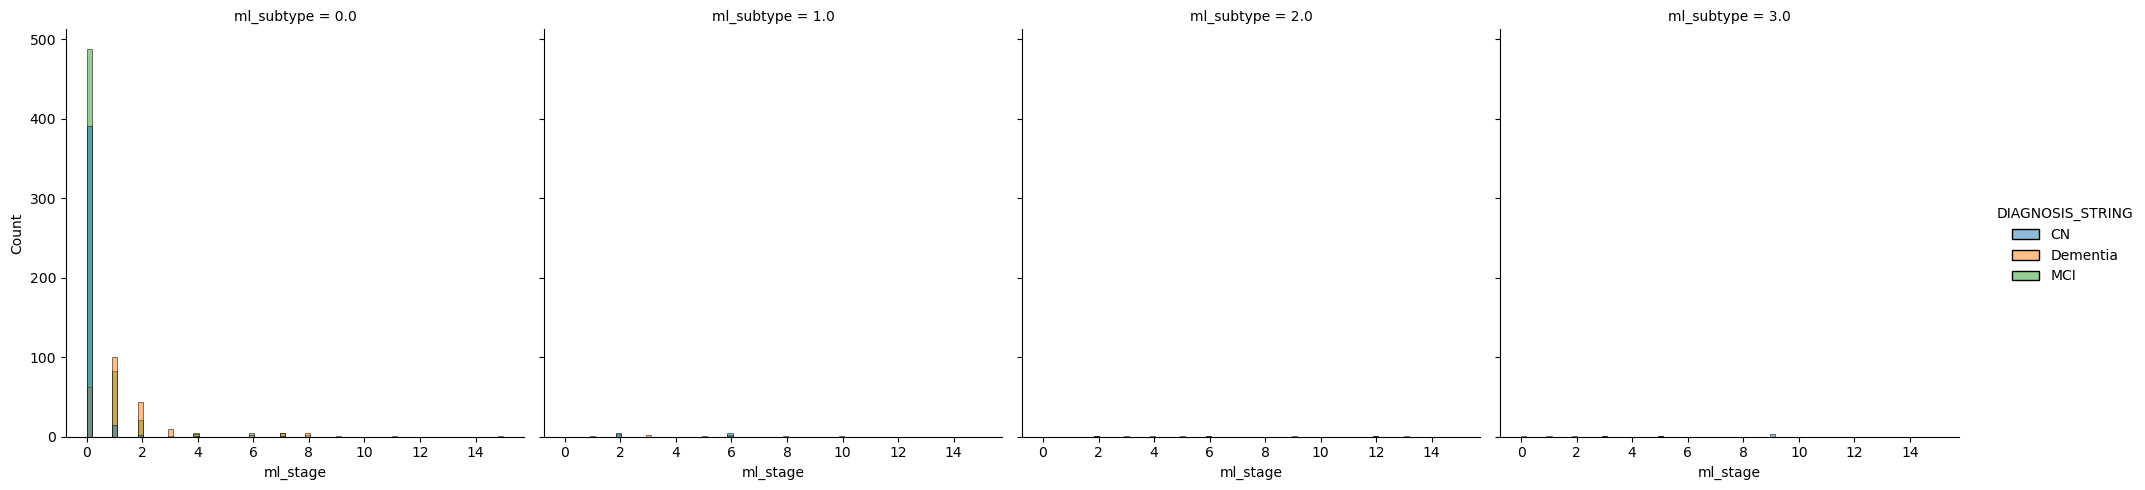

In [48]:
sns.displot(x='ml_stage',hue='DIAGNOSIS_STRING',data=zdata_mri,col='ml_subtype')

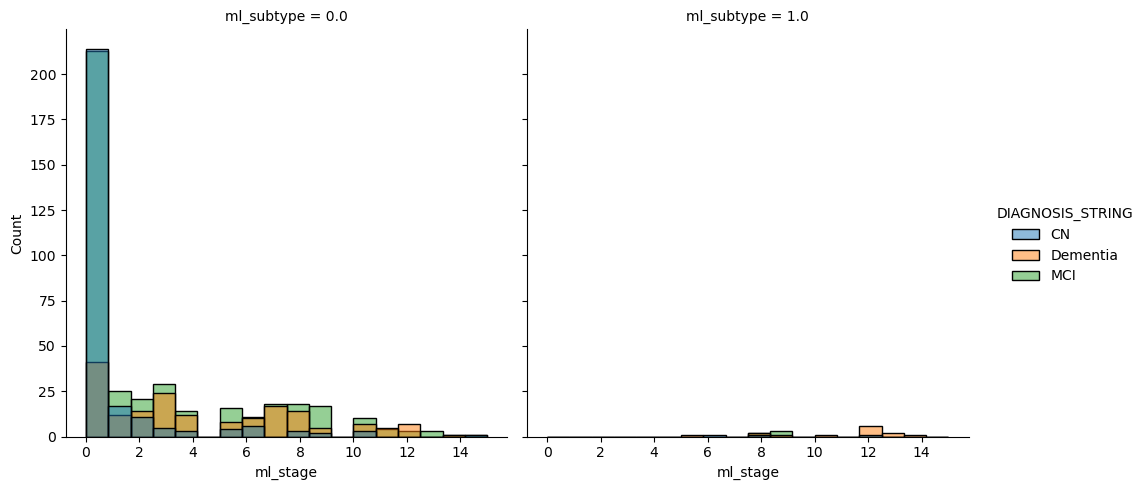

In [49]:
sns.displot(x='ml_stage',hue='DIAGNOSIS_STRING',data=zdata_ab,col='ml_subtype')

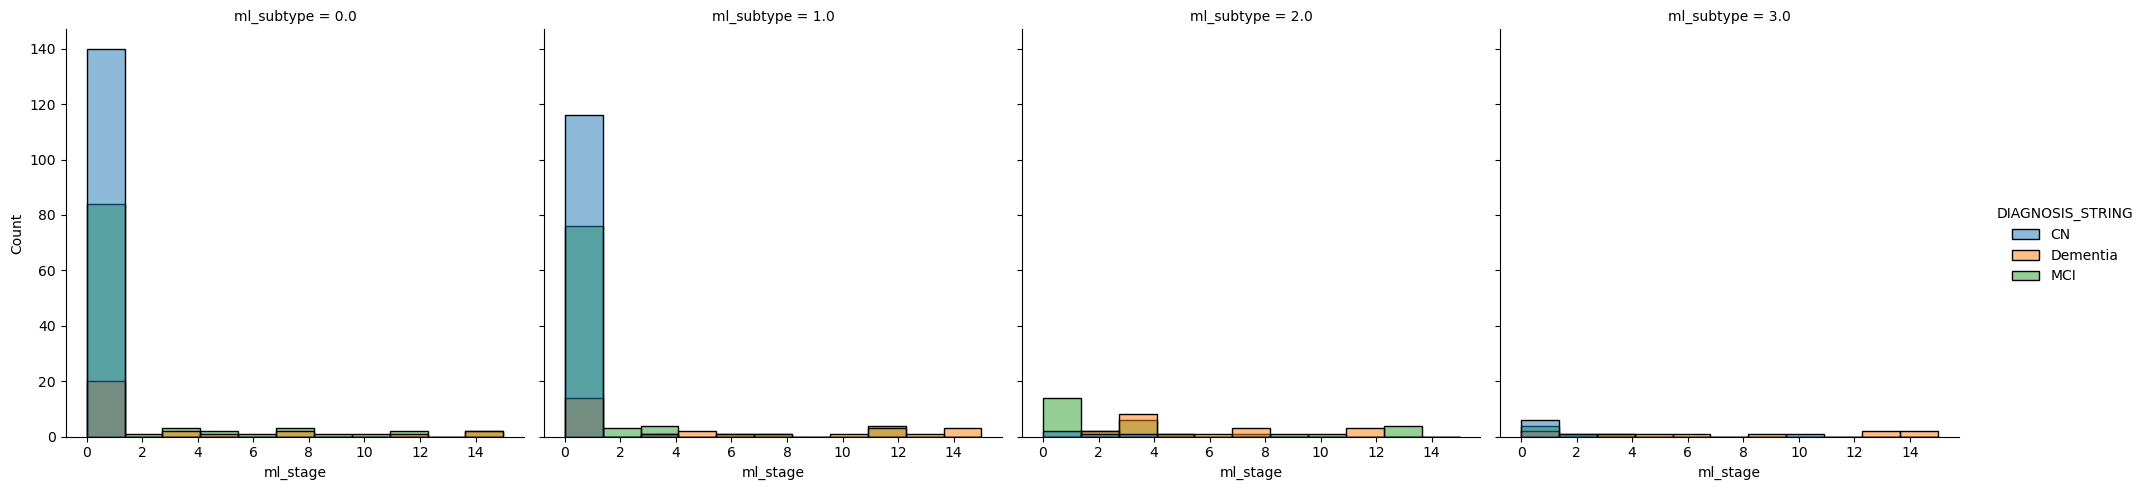

In [50]:
sns.displot(x='ml_stage',hue='DIAGNOSIS_STRING',data=zdata_tau,col='ml_subtype')

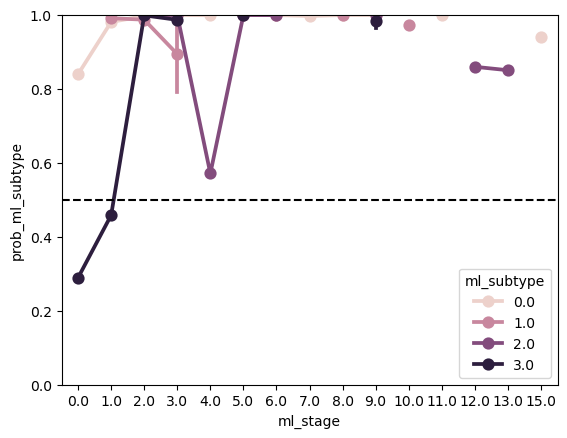

In [51]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata_mri)
            #data=zdata_mri[zdata_mri.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

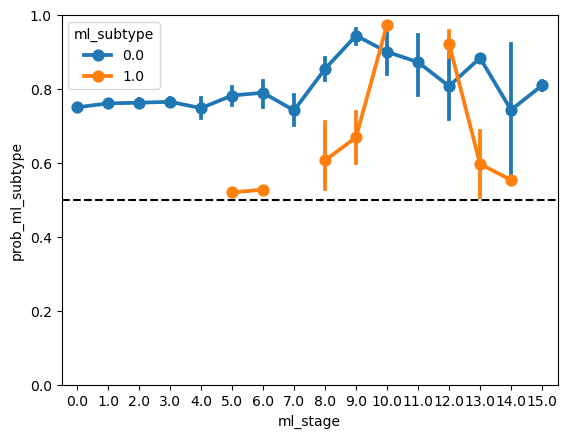

In [52]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata_ab) 
            #data=zdata_ab[zdata_ab.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

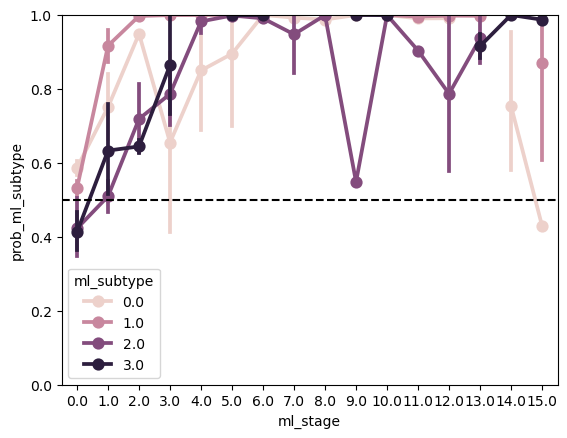

In [53]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata_tau)
            #data=zdata_tau[zdata_tau.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

## Evaluate relationships

One might want to view whether there are relationships between SuStaIn subtype and stage and other variables.

This step should probably be done after you run cross-validation (see below), but we'll do it here first to keep up the momentum

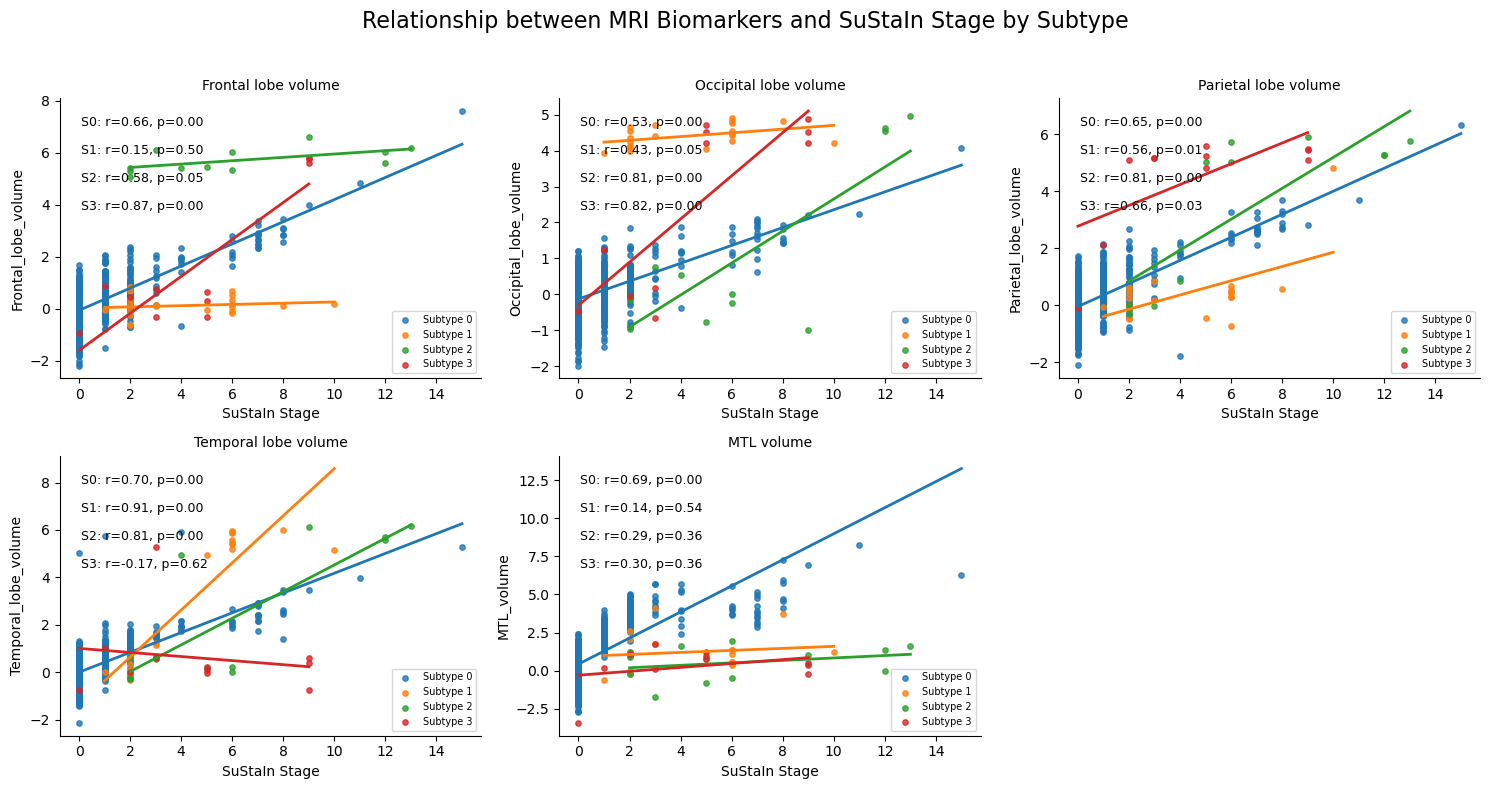

In [54]:
# Subset to exclude subtype 0
# zdata_mri_no0 = zdata_mri[zdata_mri.ml_subtype > 0]


# Plot grid size
n = len(biomarkers_mri)
cols = 3  # Number of columns in the grid
rows = int(np.ceil(n / cols))  # Calculate required rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False)
axs = axs.flatten()  # Flatten in case of 1D row

# Loop through biomarkers
for i, var in enumerate(biomarkers_mri):
    ax = axs[i]
    sns.despine()

    for subtype in [0, 1, 2, 3]:
        #subset = zdata_mri_no0[zdata_mri_no0.ml_subtype == subtype]
        subset = zdata_mri[zdata_mri.ml_subtype == subtype]
        sns.regplot(
            x='ml_stage',
            y=var,
            data=subset,
            ax=ax,
            label=f"Subtype {subtype}",
            scatter_kws={'s': 15},
            line_kws={'linewidth': 2},
            ci=None
        )

        # Correlation stats
        if not subset.empty:
            r, p = stats.pearsonr(subset[var], subset['ml_stage'])
            ax.text(0.05, 0.9 - 0.1 * subtype, f"S{subtype}: r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontsize=9)

    ax.set_title(var.replace("_", " "), fontsize=10)
    ax.set_xlabel("SuStaIn Stage")
    ax.set_ylabel(var)
    ax.legend(fontsize=7, loc="lower right")

# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Relationship between MRI Biomarkers and SuStaIn Stage by Subtype", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

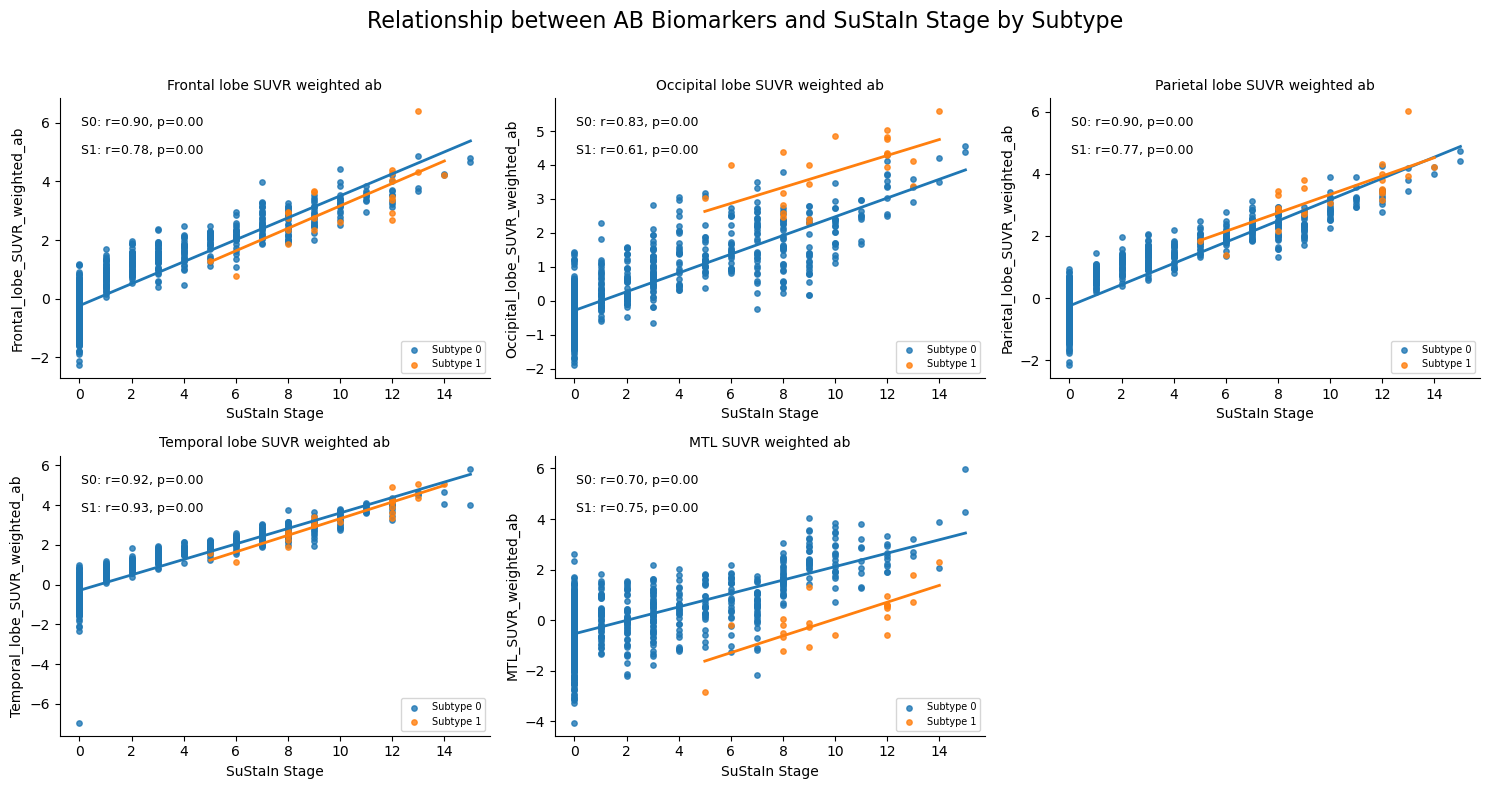

In [55]:
# Subset to exclude subtype 0
# zdata_ab_no0 = zdata_ab[zdata_ab.ml_subtype > 0]

# Plot grid size
n = len(biomarkers_ab)
cols = 3  # Number of columns in the grid
rows = int(np.ceil(n / cols))  # Calculate required rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False)
axs = axs.flatten()  # Flatten in case of 1D row

# Loop through biomarkers
for i, var in enumerate(biomarkers_ab):
    ax = axs[i]
    sns.despine()

    for subtype in [0, 1]:
        #subset = zdata_ab_no0[zdata_ab_no0.ml_subtype == subtype]
        subset = zdata_ab[zdata_ab.ml_subtype == subtype]
        sns.regplot(
            x='ml_stage',
            y=var,
            data=subset,
            ax=ax,
            label=f"Subtype {subtype}",
            scatter_kws={'s': 15},
            line_kws={'linewidth': 2},
            ci=None
        )

        # Correlation stats
        if not subset.empty:
            r, p = stats.pearsonr(subset[var], subset['ml_stage'])
            ax.text(0.05, 0.9 - 0.1 * subtype, f"S{subtype}: r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontsize=9)

    ax.set_title(var.replace("_", " "), fontsize=10)
    ax.set_xlabel("SuStaIn Stage")
    ax.set_ylabel(var)
    ax.legend(fontsize=7, loc="lower right")

# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Relationship between AB Biomarkers and SuStaIn Stage by Subtype", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

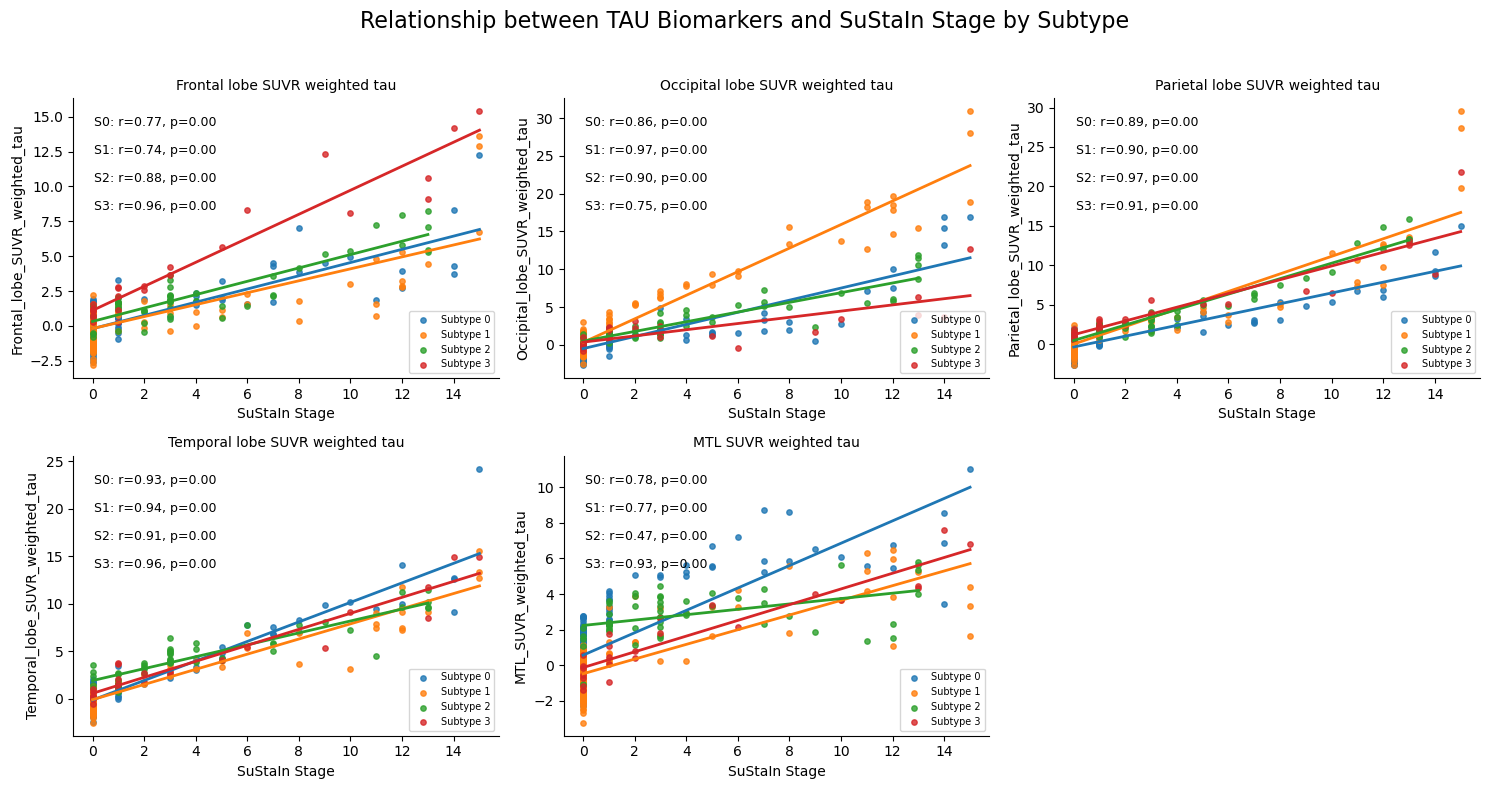

In [56]:
# Subset to exclude subtype 0
# zdata_tau_no0 = zdata_tau[zdata_tau.ml_subtype > 0]

# Plot grid size
n = len(biomarkers_tau)
cols = 3  # Number of columns in the grid
rows = int(np.ceil(n / cols))  # Calculate required rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False)
axs = axs.flatten()  # Flatten in case of 1D row

# Loop through biomarkers
for i, var in enumerate(biomarkers_tau):
    ax = axs[i]
    sns.despine()

    for subtype in [0, 1, 2, 3]:
        #subset = zdata_tau_no0[zdata_tau_no0.ml_subtype == subtype]
        subset = zdata_tau[zdata_tau.ml_subtype == subtype]
        sns.regplot(
            x='ml_stage',
            y=var,
            data=subset,
            ax=ax,
            label=f"Subtype {subtype}",
            scatter_kws={'s': 15},
            line_kws={'linewidth': 2},
            ci=None
        )

        # Correlation stats
        if not subset.empty:
            r, p = stats.pearsonr(subset[var], subset['ml_stage'])
            ax.text(0.05, 0.9 - 0.1 * subtype, f"S{subtype}: r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontsize=9)

    ax.set_title(var.replace("_", " "), fontsize=10)
    ax.set_xlabel("SuStaIn Stage")
    ax.set_ylabel(var)
    ax.legend(fontsize=7, loc="lower right")

# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Relationship between TAU Biomarkers and SuStaIn Stage by Subtype", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [57]:
# # we can also look at differences in each biomarker across subtypes

# results_mri = pd.DataFrame(index=biomarkers_mri)
# for biomarker_mri in biomarkers_mri:
#     t_1,p_1 = stats.ttest_ind(zdata_mri.loc[zdata_mri.ml_subtype==0,biomarker_mri],
#                          zdata_mri.loc[zdata_mri.ml_subtype==1,biomarker_mri],)
#     t_2,p_2 = stats.ttest_ind(zdata_mri.loc[zdata_mri.ml_subtype==0,biomarker_mri],
#                          zdata_mri.loc[zdata_mri.ml_subtype==2,biomarker_mri],)
#     t_3,p_3 = stats.ttest_ind(zdata_mri.loc[zdata_mri.ml_subtype==0,biomarker_mri],
#                          zdata_mri.loc[zdata_mri.ml_subtype==3,biomarker_mri],)
#     t_4,p_4 = stats.ttest_ind(zdata_mri.loc[zdata_mri.ml_subtype==0,biomarker_mri],
#                          zdata_mri.loc[zdata_mri.ml_subtype==4,biomarker_mri],)
#     results_mri.loc[biomarker_mri,'t_1'] = t_1
#     results_mri.loc[biomarker_mri,'p_1'] = p_1
#     results_mri.loc[biomarker_mri,'t_2'] = t_2
#     results_mri.loc[biomarker_mri,'p_2'] = p_2
#     results_mri.loc[biomarker_mri,'t_3'] = t_3
#     results_mri.loc[biomarker_mri,'p_3'] = p_3
#     results_mri.loc[biomarker_mri,'t_4'] = t_4
#     results_mri.loc[biomarker_mri,'p_4'] = p_4
    
# print(results_mri)

In [58]:
# results_ab = pd.DataFrame(index=biomarkers_ab)
# for biomarker_ab in biomarkers_ab:
#     t_1,p_1 = stats.ttest_ind(zdata_ab.loc[zdata_ab.ml_subtype==0,biomarker_ab],
#                          zdata_ab.loc[zdata_ab.ml_subtype==1,biomarker_ab],)
#     t_2,p_2 = stats.ttest_ind(zdata_ab.loc[zdata_ab.ml_subtype==0,biomarker_ab],
#                          zdata_ab.loc[zdata_ab.ml_subtype==2,biomarker_ab],)
#     results_ab.loc[biomarker_ab,'t_1'] = t_1
#     results_ab.loc[biomarker_ab,'p_1'] = p_1
#     results_ab.loc[biomarker_ab,'t_2'] = t_2
#     results_ab.loc[biomarker_ab,'p_2'] = p_2
    
# print(results_ab)

In [59]:
# results_tau = pd.DataFrame(index=biomarkers_tau)
# for biomarker_tau in biomarkers_tau:
#     t_1,p_1 = stats.ttest_ind(zdata_tau.loc[zdata_tau.ml_subtype==0,biomarker_tau],
#                          zdata_tau.loc[zdata_tau.ml_subtype==1,biomarker_tau],)
#     t_2,p_2 = stats.ttest_ind(zdata_tau.loc[zdata_tau.ml_subtype==0,biomarker_tau],
#                          zdata_tau.loc[zdata_tau.ml_subtype==2,biomarker_tau],)
#     t_3,p_3 = stats.ttest_ind(zdata_tau.loc[zdata_tau.ml_subtype==0,biomarker_tau],
#                          zdata_tau.loc[zdata_tau.ml_subtype==3,biomarker_tau],)
#     t_4,p_4 = stats.ttest_ind(zdata_tau.loc[zdata_tau.ml_subtype==0,biomarker_tau],
#                          zdata_tau.loc[zdata_tau.ml_subtype==4,biomarker_tau],)
#     results_tau.loc[biomarker_tau,'t_1'] = t_1
#     results_tau.loc[biomarker_tau,'p_1'] = p_1
#     results_tau.loc[biomarker_tau,'t_2'] = t_2
#     results_tau.loc[biomarker_tau,'p_2'] = p_2
#     results_tau.loc[biomarker_tau,'t_3'] = t_3
#     results_tau.loc[biomarker_tau,'p_3'] = p_3
#     results_tau.loc[biomarker_tau,'t_4'] = t_4
#     results_tau.loc[biomarker_tau,'p_4'] = p_4
    
# print(results_tau)

In [60]:
# # Your result dictionary (assuming these are DataFrames or convertible to them)
# heatmaps_mri = {
#     "Subtype 1": pd.DataFrame(results_mri["t_1"]),
#     "Subtype 2": pd.DataFrame(results_mri["t_2"]),
#     "Subtype 3": pd.DataFrame(results_mri["t_3"]),
#     "Subtype 4": pd.DataFrame(results_mri["t_4"]),
# }

# # Plotting setup
# n = len(heatmaps_mri)
# fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # 1 row, n columns

# for i, (title, data) in enumerate(heatmaps_mri.items()):
#     sns.heatmap(data, square=True, annot=True, cmap='RdBu_r', ax=axs[i], cbar=i == n - 1)
#     axs[i].set_title(title)

# plt.tight_layout()
# plt.show()


In [61]:
# # Your result dictionary (assuming these are DataFrames or convertible to them)
# heatmaps_ab = {
#     "Subtype 1": pd.DataFrame(results_ab["t_1"]),
#     "Subtype 2": pd.DataFrame(results_ab["t_2"]),
# }

# # Plotting setup
# n = len(heatmaps_ab)
# fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # 1 row, n columns

# for i, (title, data) in enumerate(heatmaps_ab.items()):
#     sns.heatmap(data, square=True, annot=True, cmap='RdBu_r', ax=axs[i], cbar=i == n - 1)
#     axs[i].set_title(title)

# plt.tight_layout()
# plt.show()


In [62]:
# # Your result dictionary (assuming these are DataFrames or convertible to them)
# heatmaps_tau = {
#     "Subtype 1": pd.DataFrame(results_tau["t_1"]),
#     "Subtype 2": pd.DataFrame(results_tau["t_2"]),
#     "Subtype 3": pd.DataFrame(results_tau["t_3"]),
#     "Subtype 4": pd.DataFrame(results_tau["t_4"]),
# }

# # Plotting setup
# n = len(heatmaps_tau)
# fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # 1 row, n columns

# for i, (title, data) in enumerate(heatmaps_tau.items()):
#     sns.heatmap(data, square=True, annot=True, cmap='RdBu_r', ax=axs[i], cbar=i == n - 1)
#     axs[i].set_title(title)

# plt.tight_layout()
# plt.show()


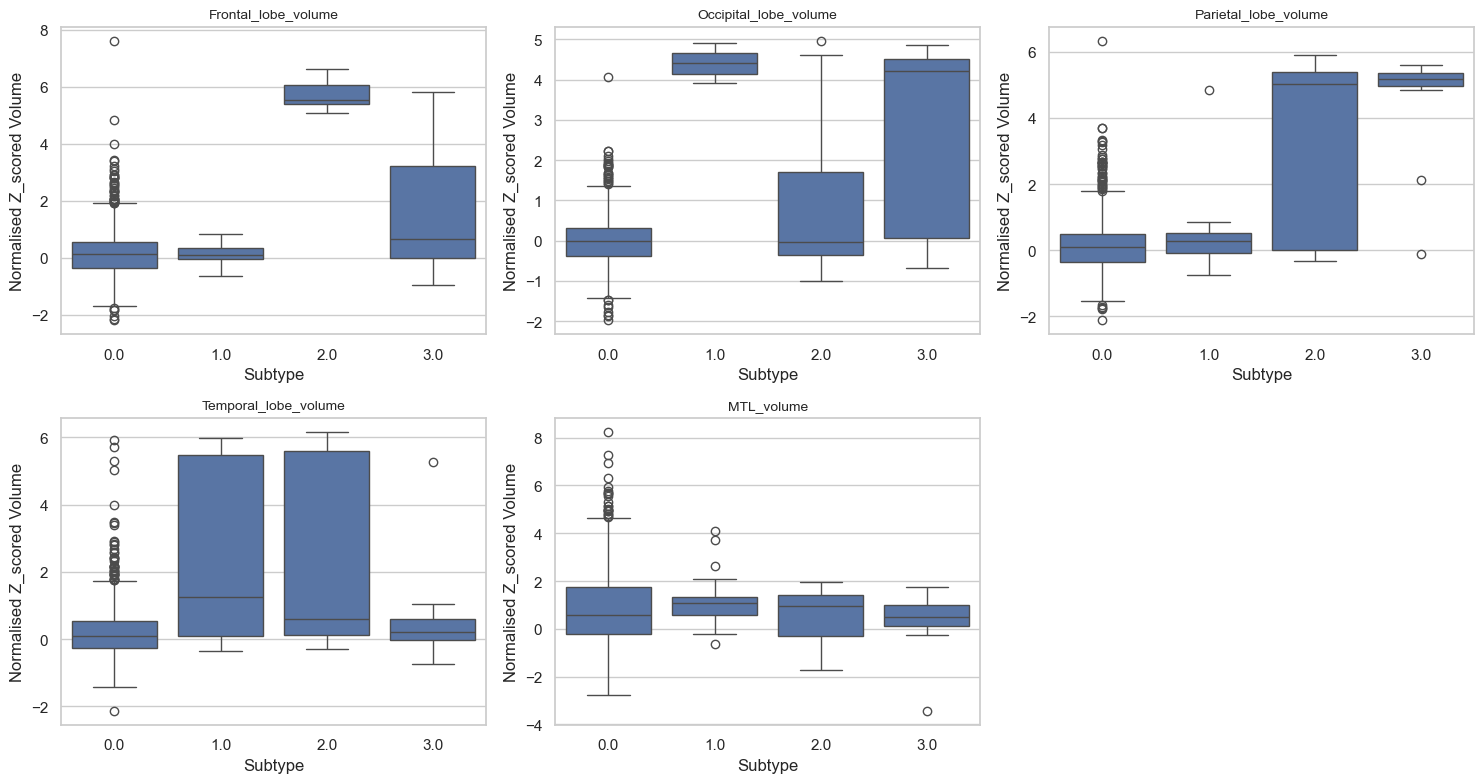

In [63]:
# Ensure consistent style
sns.set(style="whitegrid")

# Setup grid layout
n = len(biomarkers_mri)
rows = math.ceil(n / cols)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axs = axs.flatten()  # Flatten in case of 2D array

# Plot each biomarker
for i, var in enumerate(biomarkers_mri):
    sns.boxplot(x='ml_subtype', y=var, data=zdata_mri, ax=axs[i])
    axs[i].set_title(var, fontsize=10)
    axs[i].set_xlabel("Subtype")
    axs[i].set_ylabel("Normalised Z_scored Volume")

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


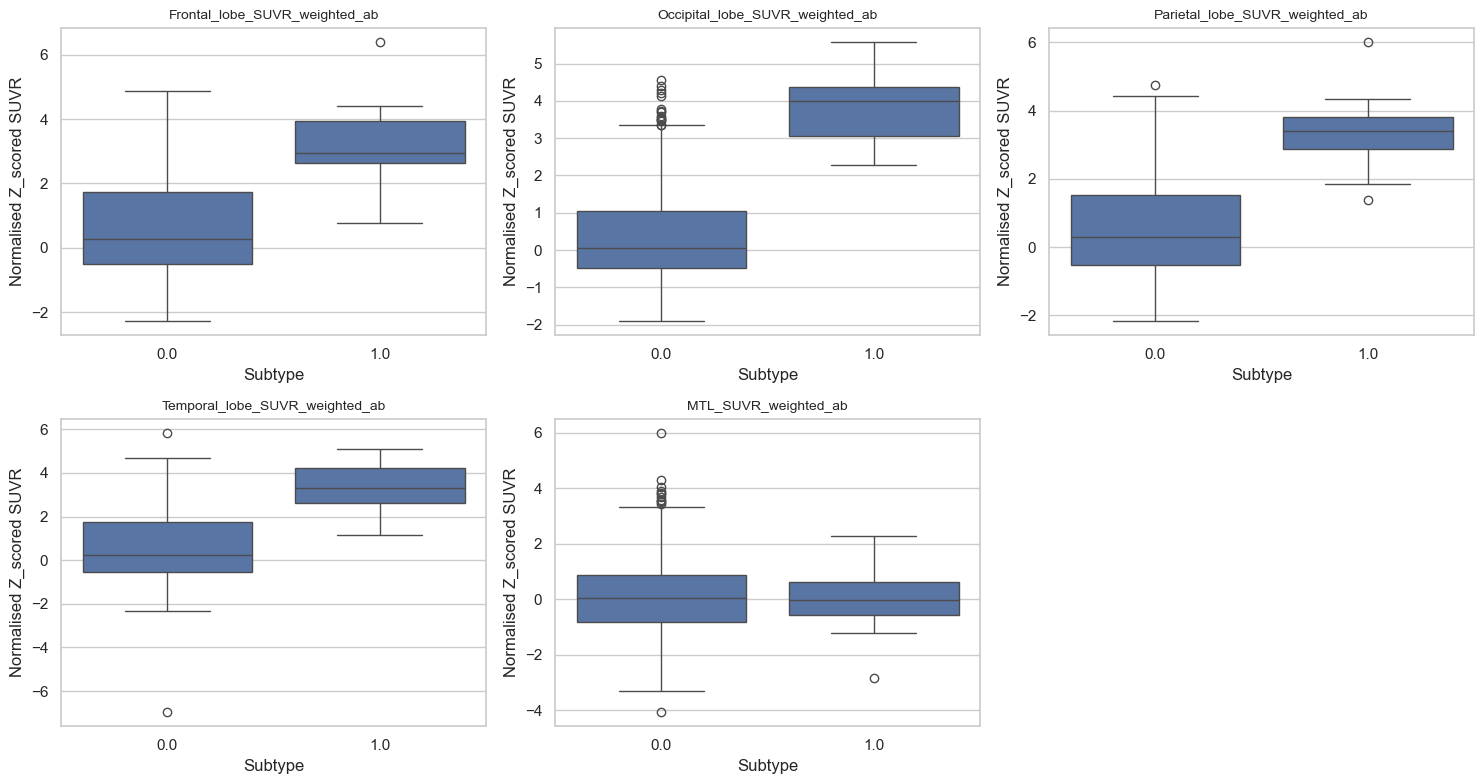

In [64]:
# Ensure consistent style
sns.set(style="whitegrid")

# Setup grid layout
n = len(biomarkers_ab)
rows = math.ceil(n / cols)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axs = axs.flatten()  # Flatten in case of 2D array

# Plot each biomarker
for i, var in enumerate(biomarkers_ab):
    sns.boxplot(x='ml_subtype', y=var, data=zdata_ab, ax=axs[i])
    axs[i].set_title(var, fontsize=10)
    axs[i].set_xlabel("Subtype")
    axs[i].set_ylabel("Normalised Z_scored SUVR")

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


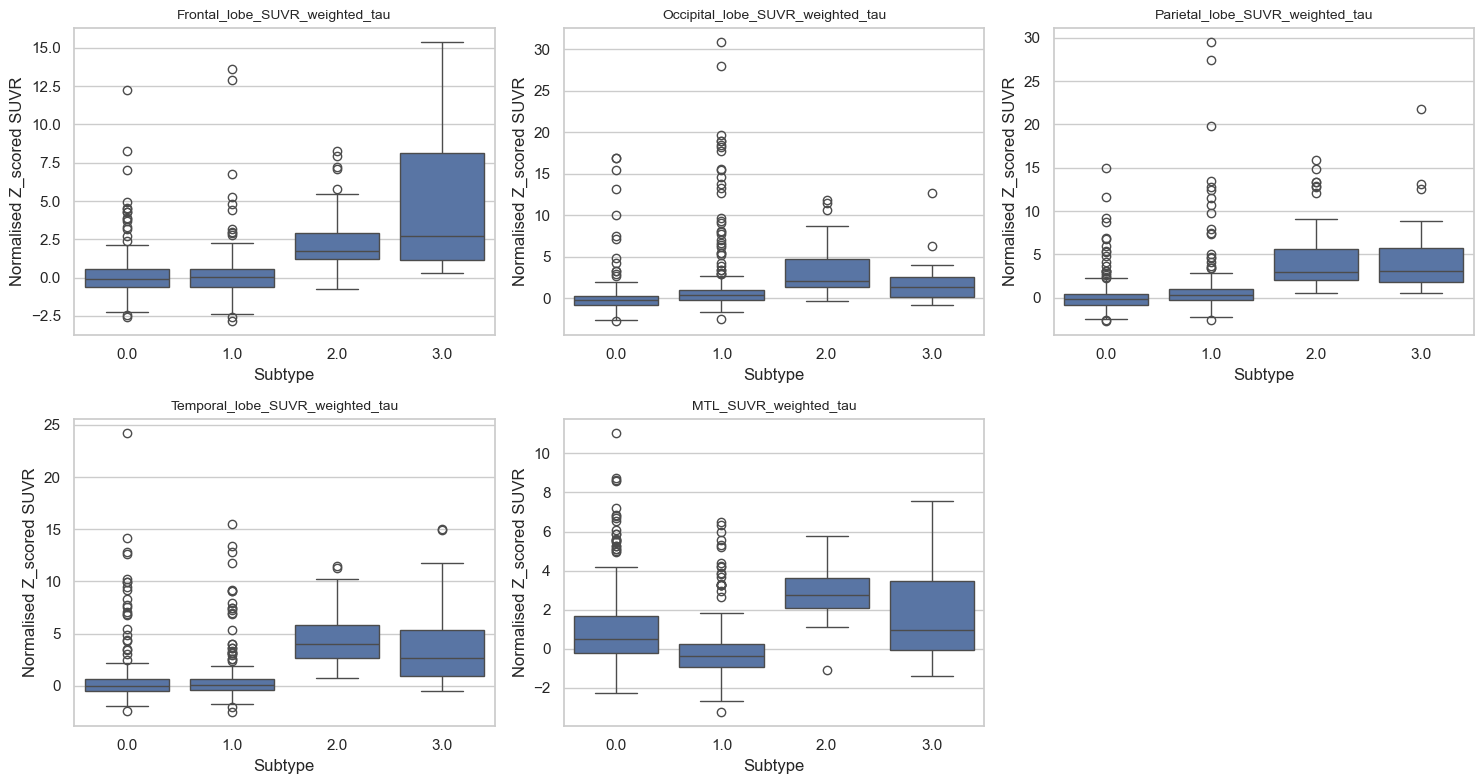

In [65]:
# Ensure consistent style
sns.set(style="whitegrid")

# Setup grid layout
n = len(biomarkers_tau)
rows = math.ceil(n / cols)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axs = axs.flatten()  # Flatten in case of 2D array

# Plot each biomarker
for i, var in enumerate(biomarkers_tau):
    sns.boxplot(x='ml_subtype', y=var, data=zdata_tau, ax=axs[i])
    axs[i].set_title(var, fontsize=10)
    axs[i].set_xlabel("Subtype")
    axs[i].set_ylabel("Normalised Z_scored SUVR")

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## Cross-validation
Finally, it is often difficult to decide how many subtypes best fit your data. This question should ideally be evaluated using cross-validation. This way, the likelihood metrics are generated for data that the model has not yet seen.

FYI we may not have nough time to run this full cross-validation during the workshop, but it's good for you to run it yourself. SuStaIn also support parallelized cross-validation!

In [66]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 10

# generate stratified cross-validation training and test set splits
labels_mri = zdata_mri.DIAGNOSIS_STRING.values
labels_ab = zdata_ab.DIAGNOSIS_STRING.values
labels_tau = zdata_tau.DIAGNOSIS_STRING.values
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it_mri = cv.split(zdata_mri, labels_mri)
cv_it_ab = cv.split(zdata_ab, labels_ab)
cv_it_tau = cv.split(zdata_tau, labels_tau)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs_mri = []
for train, test in cv_it_mri:
    test_idxs_mri.append(test)
test_idxs_mri = np.array(test_idxs_mri,dtype='object')

test_idxs_ab = []
for train, test in cv_it_ab:
    test_idxs_ab.append(test)
test_idxs_ab = np.array(test_idxs_ab,dtype='object')

test_idxs_tau = []
for train, test in cv_it_tau:
    test_idxs_tau.append(test)
test_idxs_tau = np.array(test_idxs_tau,dtype='object')

In [67]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC_mri, loglike_matrix_mri     = sustain_input_mri.cross_validate_sustain_model(test_idxs_mri)

Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10333.37018887137


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10164.38503372]
Overall ML likelihood is [-10164.38503372]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10068.53141734]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10064.74875908]
Overall ML likelihood is [-10064.74875908]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10028.93438571]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10032.24411843]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10058.72598591]
Overall ML likelihood is [-10028.93438571]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10348.33742457824


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10177.47823584]
Overall ML likelihood is [-10177.47823584]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10081.84011695]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10079.52757035]
Overall ML likelihood is [-10079.52757035]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10058.38252684]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10038.74332828]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10035.65067643]
Overall ML likelihood is [-10035.65067643]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10412.407012761734


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10230.25210214]
Overall ML likelihood is [-10230.25210214]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10122.71253559]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10122.70832669]
Overall ML likelihood is [-10122.70832669]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10082.55182924]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10080.07866595]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10115.96041799]
Overall ML likelihood is [-10080.07866595]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10368.321118490287


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10195.26775366]
Overall ML likelihood is [-10195.26775366]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10093.54022712]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10093.538398]
Overall ML likelihood is [-10093.538398]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10053.943147]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10051.84835026]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10088.58489753]
Overall ML likelihood is [-10051.84835026]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10347.592848380198


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10169.72917264]
Overall ML likelihood is [-10169.72917264]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10078.72273408]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10078.72401056]
Overall ML likelihood is [-10078.72273408]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10044.10891796]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10073.32141146]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10044.10356802]
Overall ML likelihood is [-10044.10356802]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10335.477065645293


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10252.4915578]
Overall ML likelihood is [-10252.4915578]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10130.54132937]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10080.06681823]
Overall ML likelihood is [-10080.06681823]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10044.44974831]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10075.8641048]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10044.44051129]
Overall ML likelihood is [-10044.44051129]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10418.123242120706


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10225.84731798]
Overall ML likelihood is [-10225.84731798]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10126.65398386]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10126.65288636]
Overall ML likelihood is [-10126.65288636]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10123.53686814]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10087.29352932]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10089.96642025]
Overall ML likelihood is [-10087.29352932]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10383.792138691255


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10203.63953093]
Overall ML likelihood is [-10203.63953093]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10090.05669979]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10090.04815593]
Overall ML likelihood is [-10090.04815593]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10050.40535857]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10072.19822921]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10048.02251039]
Overall ML likelihood is [-10048.02251039]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10349.597170660669


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10174.1476079]
Overall ML likelihood is [-10174.1476079]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10075.29320941]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10075.29284178]
Overall ML likelihood is [-10075.29284178]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10046.25591545]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10048.63524311]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10071.57884664]
Overall ML likelihood is [-10046.25591545]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -10417.25201174265


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10227.24856907]
Overall ML likelihood is [-10227.24856907]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10111.592138]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10111.59251474]
Overall ML likelihood is [-10111.592138]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10107.71633876]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10070.17054294]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-10074.87539102]
Overall ML likelihood is [-10070.17054294]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Average test set log-likelihood for each subtype model: [-1152.68931726 -1139.1012333  -1126.75647173 -1121.98220135]
CVIC for each subtype model: [23051.59876593 22772.8996269  22514.44369109 22424.72538533]


In [69]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC_ab, loglike_matrix_ab     = sustain_input_ab.cross_validate_sustain_model(test_idxs_ab)

Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold0_subtype0.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold0_subtype1.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold1_subtype0.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold1_subtype1.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold2_subtype0.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold2_subtype1.pickle
Loading /Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/ABOutput/pickle_files/ABOutput_fold3_subtype0.pickle
Loading /Users/yuvalkesselmeilichson/Docu

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6465.40250697]
Overall ML likelihood is [-6465.40250697]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6468.070115086652


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6452.5437734]
Overall ML likelihood is [-6452.5437734]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6494.900518897849


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6477.30213007]
Overall ML likelihood is [-6477.30213007]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6473.693727902732


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6455.16774859]
Overall ML likelihood is [-6455.16774859]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Average test set log-likelihood for each subtype model: [-719.87764368 -718.55457238]
CVIC for each subtype model: [14392.29853685 14365.25018906]


In [70]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC_tau, loglike_matrix_tau     = sustain_input_tau.cross_validate_sustain_model(test_idxs_tau)

Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6716.420505260221


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6166.96153692]
Overall ML likelihood is [-6166.96153692]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6023.0279058]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6115.31449495]
Overall ML likelihood is [-6023.0279058]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5956.77524494]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5994.60801471]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5956.70498173]
Overall ML likelihood is [-5956.70498173]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6833.564096834536


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6301.83532803]
Overall ML likelihood is [-6301.83532803]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6182.3046799]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6245.8359771]
Overall ML likelihood is [-6182.3046799]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6117.79480766]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6144.98748363]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6115.17687043]
Overall ML likelihood is [-6115.17687043]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6847.973580186514


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6303.46843513]
Overall ML likelihood is [-6303.46843513]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6189.06227766]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6259.20892499]
Overall ML likelihood is [-6189.06227766]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6120.08670151]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6159.60876583]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6121.1726898]
Overall ML likelihood is [-6120.08670151]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6821.680238848657


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6297.69810727]
Overall ML likelihood is [-6297.69810727]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6253.09101058]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6169.86177372]
Overall ML likelihood is [-6169.86177372]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6132.21740987]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6107.0534967]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6139.81453925]
Overall ML likelihood is [-6107.0534967]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6795.7468083908725


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6248.52572907]
Overall ML likelihood is [-6248.52572907]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6122.65649715]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6122.41118112]
Overall ML likelihood is [-6122.41118112]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6087.7423865]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6057.13139999]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6059.36663381]
Overall ML likelihood is [-6057.13139999]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6677.929275078685


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6166.47706668]
Overall ML likelihood is [-6166.47706668]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6049.22619113]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6055.52132609]
Overall ML likelihood is [-6049.22619113]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6028.26310494]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5983.46805401]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5987.12059827]
Overall ML likelihood is [-5983.46805401]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6924.8189087305755


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6330.49245377]
Overall ML likelihood is [-6330.49245377]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6274.43930387]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6221.41319295]
Overall ML likelihood is [-6221.41319295]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6180.59335343]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6137.40350724]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6140.58232062]
Overall ML likelihood is [-6137.40350724]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6914.172123250845


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6344.40131512]
Overall ML likelihood is [-6344.40131512]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6246.22685439]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6306.06454699]
Overall ML likelihood is [-6246.22685439]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6177.40955934]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6209.36907623]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6162.58872203]
Overall ML likelihood is [-6162.58872203]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6988.7852217502295


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6391.51597547]
Overall ML likelihood is [-6391.51597547]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6335.68421226]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6282.90082713]
Overall ML likelihood is [-6282.90082713]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6242.10339287]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6195.67901492]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6197.89938902]
Overall ML likelihood is [-6195.67901492]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6830.636598611914


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6231.48343388]
Overall ML likelihood is [-6231.48343388]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6182.53609437]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6116.14428243]
Overall ML likelihood is [-6116.14428243]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6079.1958671]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6088.81797305]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6097.02990291]
Overall ML likelihood is [-6079.1958671]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/100000 [00:00<?, ?it/s]

Average test set log-likelihood for each subtype model: [-776.79768335 -706.64142426 -699.19181666 -693.34432742]
CVIC for each subtype model: [15522.19384799 14071.16599947 13900.026311   13763.01427594]


## Choosing the optimal number of subtypes

The optimal number of subtypes is chosen using the CVIC, shown below. The CVIC is an information criterion (like the AIC/BIC/WAIC) that balances model complexity with model accuracy, with a lower CVIC indicating a better balance between the two. Generally speaking, the model with the lowest CVIC is the best. However, you do sometimes get a very small improvement (less than ~6) in the CVIC with a more complex model, in which case I would tend to favour the less complex (i.e. fewer subtypes) model.

Another useful metric to look at is the log-likelihood of each subtypes model on the test set, also shown below. A better model should show a consistent improvement in the test set log-likelihood across folds.

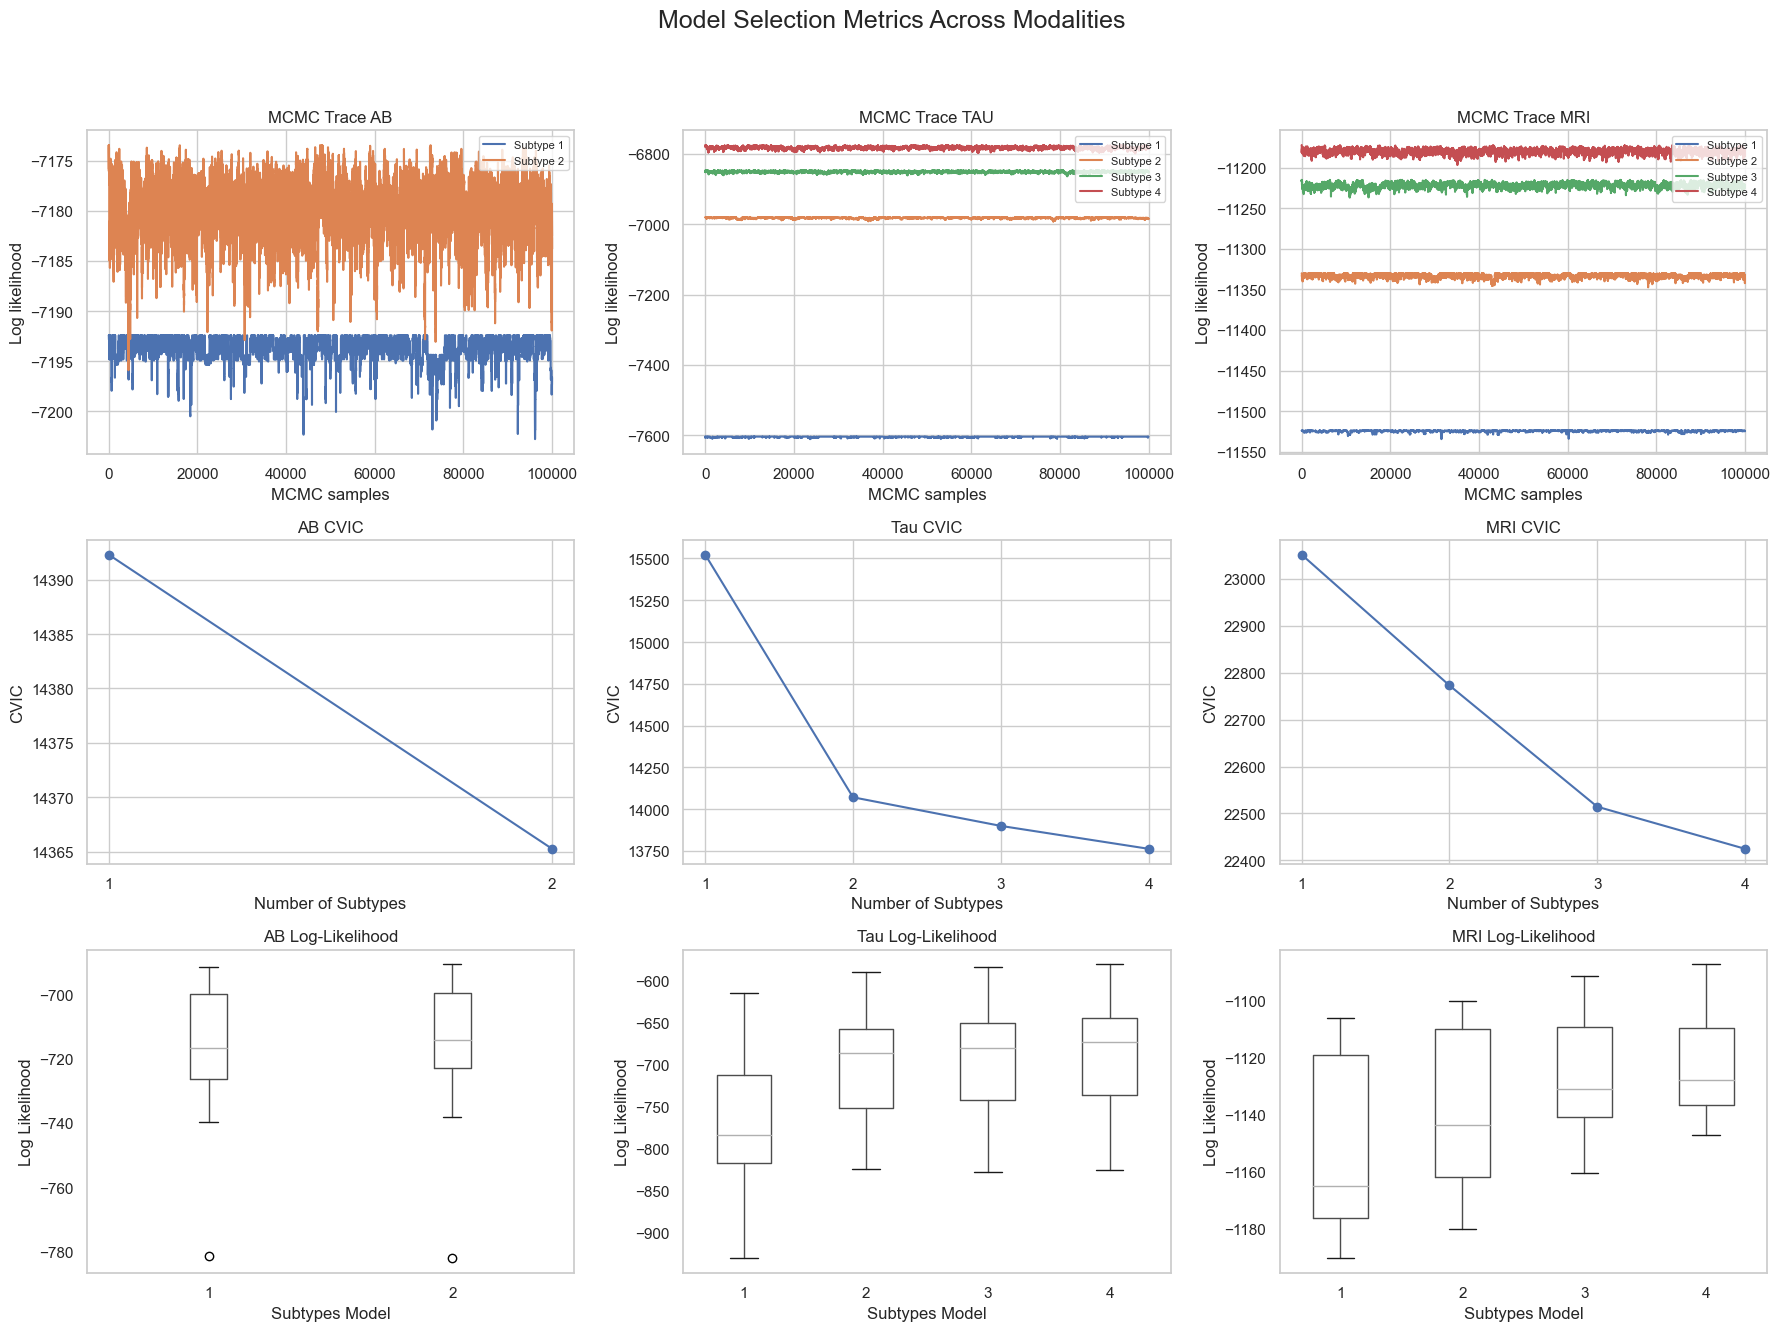

In [109]:
# # Create a 2x3 subplot layout
# fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# fig.suptitle('Model Selection Metrics Across Modalities', fontsize=16)

# # --- First row: CVIC plots ---
# modalities = ['AB', 'Tau', 'MRI']
# cvics = [CVIC_ab, CVIC_tau, CVIC_mri]
# n_s_max = [N_S_max_ab, N_S_max_tau, N_S_max_mri]

# for i, (mod, cvic, nmax) in enumerate(zip(modalities, cvics, n_s_max)):
#     axs[0, i].plot(np.arange(1, nmax + 1), cvic, marker='o')
#     axs[0, i].set_title(f'{mod} CVIC')
#     axs[0, i].set_xlabel('Number of Subtypes')
#     axs[0, i].set_ylabel('CVIC')
#     axs[0, i].set_xticks(np.arange(1, nmax + 1))

# # --- Second row: Log-likelihood boxplots ---
# loglike_matrices = [loglike_matrix_ab, loglike_matrix_tau, loglike_matrix_mri]
# s_max = [sustain_input_ab.N_S_max, sustain_input_tau.N_S_max, sustain_input_mri.N_S_max]

# for i, (mod, ll_mat, s) in enumerate(zip(modalities, loglike_matrices, s_max)):
#     # shift labels by +1
#     df_loglike = pd.DataFrame(data=ll_mat, columns=[f's_{j+1}' for j in range(s)])
#     df_loglike.boxplot(grid=False, ax=axs[1, i])
#     axs[1, i].set_title(f'{mod} Log-Likelihood')
#     axs[1, i].set_xlabel('Subtypes Model')
#     axs[1, i].set_ylabel('Log Likelihood')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("model_selection_metric_across_modalities.png", dpi=300)
# plt.show()


# Create a 3x3 subplot layout
fig, axs = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Model Selection Metrics Across Modalities', fontsize=18)

modalities = ['AB', 'Tau', 'MRI']

# --- Row 1: MCMC trace plots ---
modality_info = [
    ("AB", N_S_max_ab, output_folder_ab, dataset_name_ab),
    ("TAU", N_S_max_tau, output_folder_tau, dataset_name_tau),
    ("MRI", N_S_max_mri, output_folder_mri, dataset_name_mri)
]

for col, (mod, N_S_max, output_folder, dataset_name) in enumerate(modality_info):
    all_samples_modality = []

    for s in range(N_S_max):
        pickle_filename = f"{output_folder}/pickle_files/{dataset_name}_subtype{s}.pickle"
        pk = pd.read_pickle(pickle_filename)
        samples_likelihood = pk["samples_likelihood"]

        all_samples_modality.extend(samples_likelihood)
        axs[0, col].plot(range(len(samples_likelihood)), samples_likelihood, label=f"Subtype {s+1}")

    ymin, ymax = min(all_samples_modality), max(all_samples_modality)
    margin = 0.05 * (ymax - ymin) if ymax != ymin else 1
    axs[0, col].set_ylim(ymin - margin, ymax + margin)

    axs[0, col].set_title(f"MCMC Trace {mod}")
    axs[0, col].set_xlabel("MCMC samples")
    axs[0, col].set_ylabel("Log likelihood")
    axs[0, col].legend(loc="upper right", fontsize=8)

# --- Row 2: CVIC plots ---
cvics = [CVIC_ab, CVIC_tau, CVIC_mri]
n_s_max = [N_S_max_ab, N_S_max_tau, N_S_max_mri]

for i, (mod, cvic, nmax) in enumerate(zip(modalities, cvics, n_s_max)):
    axs[1, i].plot(np.arange(1, nmax + 1), cvic, marker='o')
    axs[1, i].set_title(f'{mod} CVIC')
    axs[1, i].set_xlabel('Number of Subtypes')
    axs[1, i].set_ylabel('CVIC')
    axs[1, i].set_xticks(np.arange(1, nmax + 1))

# --- Row 3: Log-likelihood boxplots ---
loglike_matrices = [loglike_matrix_ab, loglike_matrix_tau, loglike_matrix_mri]
s_max = [sustain_input_ab.N_S_max, sustain_input_tau.N_S_max, sustain_input_mri.N_S_max]

for i, (mod, ll_mat, s) in enumerate(zip(modalities, loglike_matrices, s_max)):
    df_loglike = pd.DataFrame(data=ll_mat, columns=[str(j+1) for j in range(s)])  # shift labels by +1
    df_loglike.boxplot(grid=False, ax=axs[2, i])
    axs[2, i].set_title(f'{mod} Log-Likelihood')
    axs[2, i].set_xlabel('Subtypes Model')
    axs[2, i].set_ylabel('Log Likelihood')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("model_selection_all_metrics.png", dpi=300)
plt.show()


Another useful output of the cross-validation that you can look at are positional variance diagrams averaged across cross-validation folds. These give you an idea of the variability in the progression patterns across different training datasets.

In [83]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max_mri):
    sustain_input_mri.combine_cross_validated_sequences(i+1, N_folds)

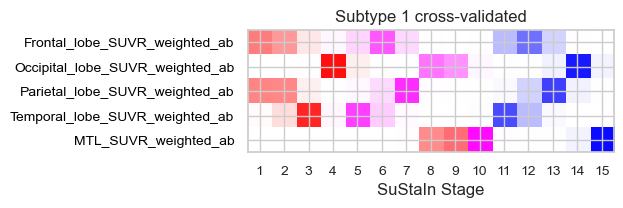

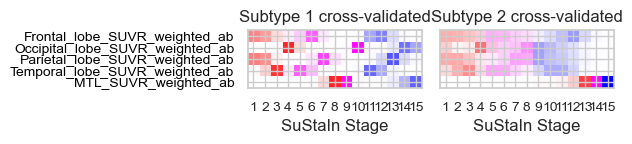

In [84]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max_ab):
    sustain_input_ab.combine_cross_validated_sequences(i+1, N_folds)

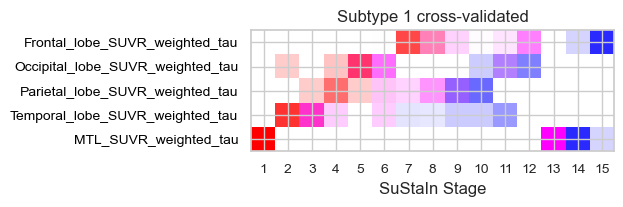

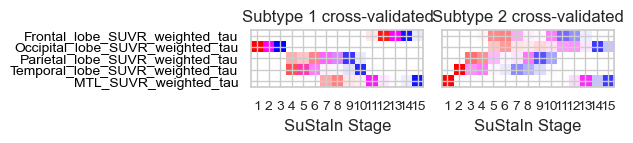

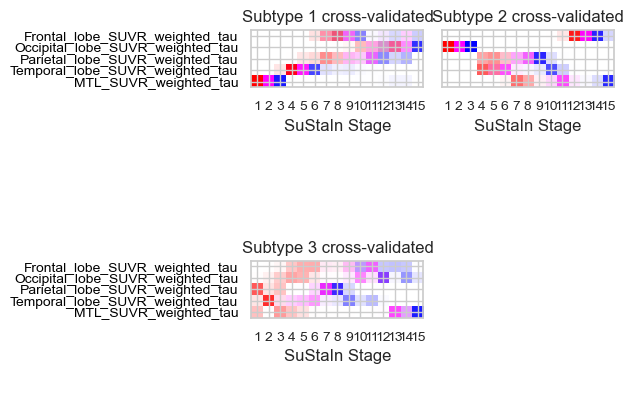

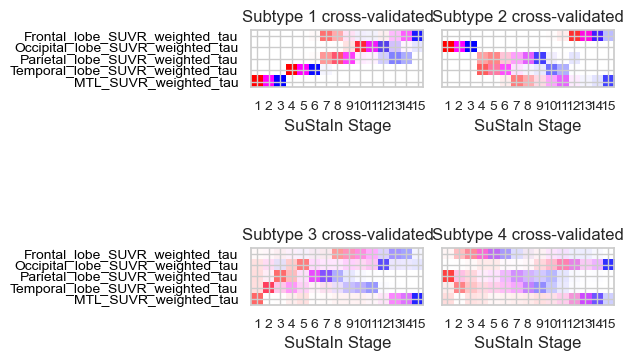

In [85]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max_tau):
    sustain_input_tau.combine_cross_validated_sequences(i+1, N_folds)

/opt/anaconda3/envs/sustain_env/lib/python3.8/site-packages/pySuStaIn/ZscoreSustain.py:505: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
/opt/anaconda3/envs/sustain_env/lib/python3.8/site-packages/pySuStaIn/AbstractSustain.py:523: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


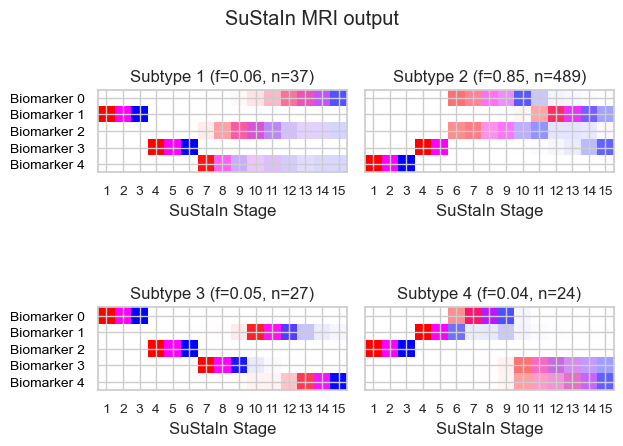

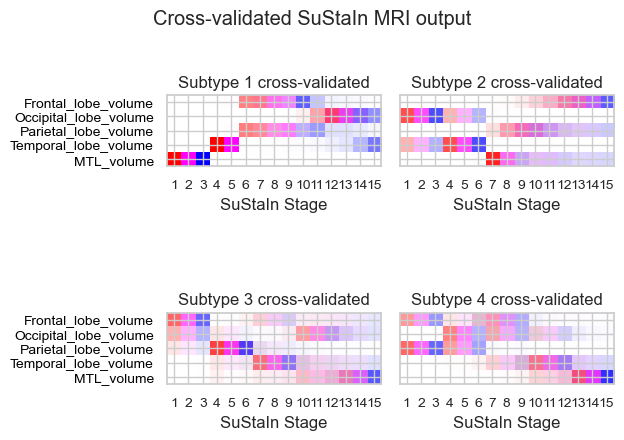

In [73]:
N_S_selected_mri = 4

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_mri,samples_sequence_mri,samples_f_mri,M,subtype_order=(0,1,2,3))
mri= plt.suptitle('SuStaIn MRI output')

sustain_input_mri.combine_cross_validated_sequences(N_S_selected_mri, N_folds)
mri= plt.suptitle('Cross-validated SuStaIn MRI output')

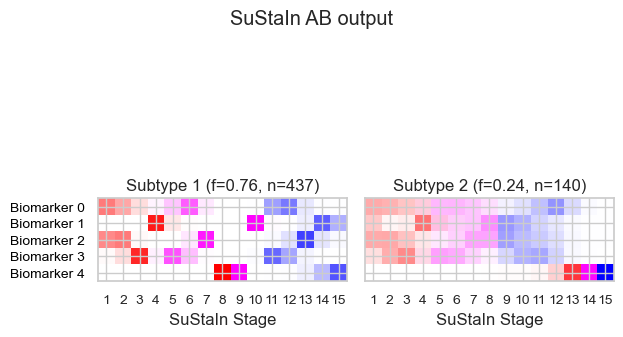

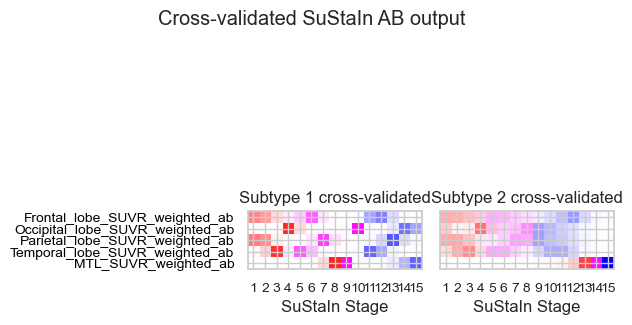

In [74]:
N_S_selected_ab = 2

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_ab,samples_sequence_ab,samples_f_ab,M,subtype_order=(0,1))
ab = plt.suptitle('SuStaIn AB output')

sustain_input_ab.combine_cross_validated_sequences(N_S_selected_ab, N_folds)
ab = plt.suptitle('Cross-validated SuStaIn AB output')

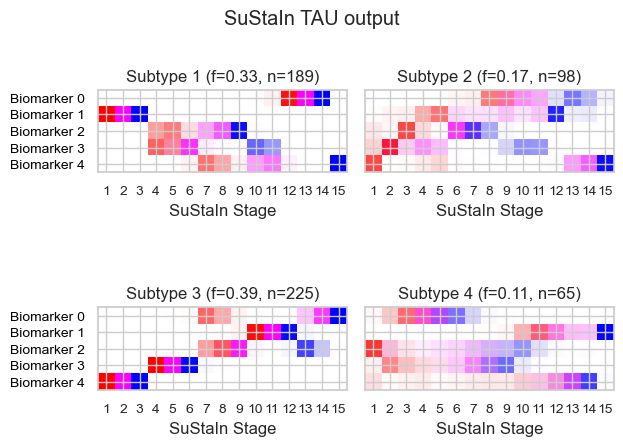

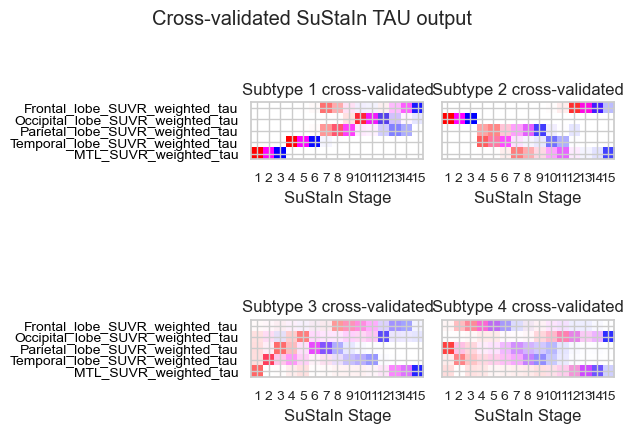

In [75]:
N_S_selected_tau = 4

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input_tau,samples_sequence_tau,samples_f_tau,M,subtype_order=(0,1,2,3))
tau = plt.suptitle('SuStaIn TAU output')

sustain_input_tau.combine_cross_validated_sequences(N_S_selected_tau, N_folds)
tau = plt.suptitle('Cross-validated SuStaIn TAU output')

## Output sustain data into the datasets

In [76]:
# Create a new copy of the dataframe
zdata_mri_sustain = zdata_mri.copy()

# Number of subtypes
s = 3

# Load the SuStaIn pickle file
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(s) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_mri)

# Add main SuStaIn output columns
for variable in ['ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage']:
    zdata_mri_sustain[variable] = pk_mri[variable]

# Add probability for each subject belonging to each subtype
for i in range(s):
    zdata_mri_sustain[f'prob_S{i}'] = pk_mri['prob_subtype'][:, i]

# zdata_tau_sustain now contains the SuStaIn results
zdata_mri_sustain.head()

RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2010-12-21               CN        1.0   91     26.0    0.0      14.0   
1   30  2007-11-13         Dementia        3.0  100     22.0    0.0      19.0   
2   72  2019-10-16               CN        1.0   90     28.0    0.0      16.0   
3   74  2021-01-11               CN        1.0   98     29.0    0.0      20.0   
4   86  2006-05-08               CN        1.0  100      0.0    0.0      18.0   

  PTGENDER  AGE_RETIRE  ...  Temporal_lobe_Asymmetry_MRI_R  \
0      1.0        76.0  ...                         0.0272   
1      2.0        59.0  ...                        -0.0664   
2      1.0         0.0  ...                        -0.0257   
3      1.0        74.0  ...                        -0.0171   
4      2.0        66.0  ...                        -0.0070   

   MTL_Asymmetry_MRI_L  MTL_Asymmetry_MRI_R  ml_subtype  prob_ml_subtype  \
0              -0.0410               0.0410         0.0         0.645338   
1               0.0061              -0.0061         0.0         0.999489   
2              -0.0295               0.0295         0.0         0.748911   
3               0.0618              -0.0618         0.0         0.999795   
4               0.0647              -0.0647         0.0         0.845885   

   ml_stage  prob_ml_stage   prob_S0   prob_S1   prob_S2  
0       0.0       0.086658  0.645338  0.110223  0.032885  
1       1.0       0.426227  0.999489  0.000147  0.000256  
2       0.0       0.143419  0.748911  0.066094  0.121897  
3       2.0       0.425670  0.999795  0.000042  0.000125  
4       0.0       0.242128  0.845885  0.063910  0.058784  

[5 rows x 33 columns]

In [77]:
# Create a new copy of the dataframe
zdata_ab_sustain = zdata_ab.copy()

# Number of subtypes
s = 1

# Load the SuStaIn pickle file
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(s) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)

# Add main SuStaIn output columns
for variable in ['ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage']:
    zdata_ab_sustain[variable] = pk_ab[variable]

# Add probability for each subject belonging to each subtype
for i in range(s):
    zdata_ab_sustain[f'prob_S{i}'] = pk_ab['prob_subtype'][:, i]

# zdata_ab_sustain now contains the SuStaIn results
zdata_ab_sustain.head()


RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   23  2012-12-27               CN        1.0   91     28.0    0.0      14.0   
1   42  2011-04-13         Dementia        3.0   93     23.0    0.0      18.0   
2   58  2011-04-27               CN        1.0   90     29.0    1.0      16.0   
3   61  2013-02-06              MCI        2.0   97     25.0    0.0      15.0   
4   74  2012-12-11               CN        1.0   98     30.0    0.0      20.0   

  PTGENDER  AGE_RETIRE  ...  Parietal_lobe_Asymmetry_ab_R  \
0      1.0        55.0  ...                        0.0685   
1      1.0        55.0  ...                       -0.0098   
2      1.0         0.0  ...                        0.0073   
3      2.0        62.0  ...                       -0.0174   
4      1.0        74.0  ...                       -0.0033   

   Temporal_lobe_Asymmetry_ab_L  Temporal_lobe_Asymmetry_ab_R  \
0                       -0.0575                        0.0575   
1                       -0.0025                        0.0025   
2                       -0.0063                        0.0063   
3                        0.0382                       -0.0382   
4                       -0.0201                        0.0201   

   MTL_Asymmetry_ab_L  MTL_Asymmetry_ab_R  ml_subtype  prob_ml_subtype  \
0             -0.0083              0.0083         0.0         0.757280   
1             -0.0158              0.0158         0.0         0.744181   
2              0.0278             -0.0278         0.0         0.747803   
3              0.0284             -0.0284         0.0         0.769564   
4             -0.0162              0.0162         0.0         0.743888   

   ml_stage  prob_ml_stage   prob_S0  
0       0.0       0.192612  0.757280  
1       0.0       0.420652  0.744181  
2       0.0       0.420989  0.747803  
3       0.0       0.211044  0.769564  
4       0.0       0.338973  0.743888  

[5 rows x 30 columns]

In [78]:
# Create a new copy of the dataframe
zdata_tau_sustain = zdata_tau.copy()

# Number of subtypes
s = 3

# Load the SuStaIn pickle file
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(s) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)

# Add main SuStaIn output columns
for variable in ['ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage']:
    zdata_tau_sustain[variable] = pk_tau[variable]

# Add probability for each subject belonging to each subtype
for i in range(s):
    zdata_tau_sustain[f'prob_S{i}'] = pk_tau['prob_subtype'][:, i]

# zdata_tau_sustain now contains the SuStaIn results
zdata_tau_sustain.head()


RID    EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  PTEDUCAT  \
0   96  2016-03-07               CN        1.0   99     29.0    0.0      20.0   
1  112  2016-02-05         Dementia        3.0   90     25.0    1.0      18.0   
2  205  2020-07-15               CN        1.0   86     30.0    0.0      18.0   
3  303  2016-04-27               CN        1.0  104     30.0    1.0      16.0   
4  420  2018-10-16              MCI        2.0   93     28.0    0.0      19.0   

  PTGENDER  AGE_RETIRE  ...  Temporal_lobe_Asymmetry_tau_R  \
0      1.0        67.0  ...                        -0.0040   
1      1.0        59.0  ...                         0.0110   
2      2.0        61.0  ...                        -0.0261   
3      1.0        61.0  ...                         0.0134   
4      1.0        78.0  ...                         0.0051   

   MTL_Asymmetry_tau_L  MTL_Asymmetry_tau_R  ml_subtype  prob_ml_subtype  \
0               0.0183              -0.0183         1.0         0.548642   
1              -0.0364               0.0364         3.0         0.732568   
2              -0.0231               0.0231         0.0         0.555808   
3              -0.0055               0.0055         0.0         0.379709   
4               0.0113              -0.0113         0.0         0.603582   

   ml_stage  prob_ml_stage   prob_S0   prob_S1   prob_S2  
0       0.0       0.391306  0.168116  0.548642  0.078518  
1       3.0       0.414628  0.000117  0.000023  0.267292  
2       0.0       0.419803  0.555808  0.293960  0.073918  
3       0.0       0.219264  0.379709  0.268484  0.152602  
4       0.0       0.465993  0.603582  0.236943  0.121787  

[5 rows x 32 columns]

In [79]:
# Export final datasets to CSV
##1. Train set: MRI Atrophy
export1_csv = "Train_MRI_SuStaIn_1.csv"
zdata_mri_sustain.to_csv(export1_csv, index=False)
print(f"\nDataset successfully exported as: {export1_csv}")

##2. Train set: PET Amyloid Beta
export2_csv = "Train_AB_SuStaIn_2.csv"
zdata_ab_sustain.to_csv(export2_csv, index=False)
print(f"\nDataset successfully exported as: {export2_csv}")

##3. Train set: PET Tau
export3_csv = "Train_TAU_SuStaIn_3.csv"
zdata_tau_sustain.to_csv(export3_csv, index=False)
print(f"\nDataset successfully exported as: {export3_csv}")



Dataset successfully exported as: Train_MRI_SuStaIn_1.csv

Dataset successfully exported as: Train_AB_SuStaIn_2.csv

Dataset successfully exported as: Train_TAU_SuStaIn_3.csv
